<a href="https://colab.research.google.com/github/oguiza/DataAugmentation/blob/master/VPP311021_01490.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries 31/10 06:00

In [44]:
import torch
print(f'torch          : {torch.__version__}')
if torch.cuda.is_available():
    print(f'gpu            : {torch.cuda.get_device_name(0)}')

torch          : 1.9.0+cu111
gpu            : Tesla P100-PCIE-16GB


In [2]:
# **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
stable = False # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null
!pip install kaggle -U  >> /dev/null
!pip install pandas -U  >> /dev/null
# ⚠️ REMEMBER TO RESTART (NOT RECONNECT/ RESET) THE KERNEL/ RUNTIME ONCE THE INSTALLATION IS FINISHED

In [3]:
def is_kaggle():
    cwd = !pwd
    return cwd[0] == '/kaggle/working'

In [4]:
from tsai.all import *
my_setup()

os             : Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
python         : 3.7.12
tsai           : 0.2.23
fastai         : 2.5.3
fastcore       : 1.3.26
torch          : 1.9.0+cu111
n_cpus         : 2
device         : cuda (Tesla P100-PCIE-16GB)


In [5]:
if is_colab(): 
    maybe_mount_drive() # maybe_mount_gdrive

In [6]:
PATH = Path("./drive/MyDrive/kaggle/VPP") if is_colab() else Path("./VPP")
if not os.path.exists(PATH): os.mkdir(PATH)
assert os.path.exists(PATH)
for d in ['data', 'models', 'submissions']:
    if not os.path.exists(PATH/d): os.mkdir(PATH/d)
    assert os.path.exists(PATH/d)
if is_colab(): INPUT_PATH = PATH/'data'
else: INPUT_PATH = Path('../input/ventilator-pressure-prediction')
if not os.path.exists(INPUT_PATH): os.mkdir(INPUT_PATH)
assert os.path.exists(INPUT_PATH)
PATH, INPUT_PATH

(Path('drive/MyDrive/kaggle/VPP'), Path('drive/MyDrive/kaggle/VPP/data'))

In [7]:
#export
def maybe_load_kaggle_json():
    if not os.path.isfile("../root/.kaggle/kaggle.json"):
        from google.colab import files
        uploaded = files.upload()
        for fn in uploaded.keys():
            print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
        !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    print(f"~/.kaggle/kaggle.json exists: {os.path.isfile('../root/.kaggle/kaggle.json')}")
    
if is_colab(): maybe_load_kaggle_json()

~/.kaggle/kaggle.json exists: True


# Code

In [8]:
class ShowGraph(Callback):
    "(Modified) Update a graph of training and validation loss"
    order,run_valid=65,False
    names = ['train', 'valid']
    def __init__(self, plot_metrics:bool=True, final_losses:bool=False):
        store_attr("plot_metrics,final_losses")


    def before_fit(self):
        self.run = not hasattr(self.learn, 'lr_finder') and not hasattr(self, "gather_preds")
        if not(self.run): return
        self.nb_batches = []

    def after_train(self): self.nb_batches.append(self.train_iter)

    def after_epoch(self):
        "Plot validation loss in the pbar graph"
        if not self.nb_batches: return
        rec = self.learn.recorder
        iters = range_of(rec.losses)
        val_pos = rec.metric_names.index('valid_loss') - 1
        val_losses = [v[val_pos] for v in rec.values]
        x_bounds = (0, (self.n_epoch - len(self.nb_batches)) * self.nb_batches[0] + len(rec.losses))
        y_min = min((min(rec.losses), min(val_losses)))
        y_max = max((max(rec.losses), max(val_losses)))
        margin = (y_max - y_min) * .05
        y_bounds = (y_min - margin, y_max + margin)
        self.update_graph([(iters, rec.losses), (self.nb_batches, val_losses)], x_bounds, y_bounds)

    def after_fit(self):
        plt.close(self.graph_ax.figure)
        if self.plot_metrics: self.learn.plot_metrics(final_losses=self.final_losses)

    def update_graph(self, graphs, x_bounds=None, y_bounds=None, figsize=(6,4)):
        if not hasattr(self, 'graph_fig'):
            self.graph_fig, self.graph_ax = plt.subplots(1, figsize=figsize)
            self.graph_out = display(self.graph_ax.figure, display_id=True)
        self.graph_ax.clear()
        if len(self.names) < len(graphs): self.names += [''] * (len(graphs) - len(self.names))
        for g,n in zip(graphs,self.names): self.graph_ax.plot(*g, label=n)
        self.graph_ax.legend(loc='upper right')
        self.graph_ax.grid(color='gainsboro', linewidth=.5)
        if x_bounds is not None: self.graph_ax.set_xlim(*x_bounds)
        if y_bounds is not None: self.graph_ax.set_ylim(*y_bounds)
        self.graph_ax.set_title(f'Losses\nepoch: {self.epoch +1}/{self.n_epoch}')
        self.graph_out.update(self.graph_ax.figure)

In [9]:
def log_tfm(o, inplace=False):
    "Log transforms an array´like object with positive and/or negative values"
    if inplace:
        o[o > 0] = np.log1p(o[o > 0])
        o[o < 0] = (-np.log1p(np.abs(o[o < 0])))
        return o
    else:
        if hasattr(o, "clone"): output = o.clone()
        elif hasattr(o, "copy"): output = o.copy()
        output[output > 0] = np.log1p(output[output > 0])
        output[output < 0] = (-np.log1p(np.abs(output[output < 0])))
        return output

In [10]:
class MaskedLoss(Module):
    def __init__(self, crit):
        self.crit = crit
    def forward(self, inp, targ):
        mask = torch.isnan(targ)
        inp = inp[~mask]
        targ = targ[~mask]
        return self.crit(inp, targ)

In [11]:
class MaskedLabelSmoothing(Module):
    crit = LabelSmoothingCrossEntropyFlat()

    def forward(self, inp, targ):
        mask = torch.isnan(targ)
        inp = inp[~mask]
        targ = targ[~mask]
        return self.crit(inp, targ)

In [12]:
def masked_accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    mask = targ != -1
    inp = inp[mask].argmax(dim=axis)
    targ = targ[mask]
    return (inp == targ).float().mean()

In [13]:
def cat_mae(inp, targ):
    "Mean absolute error between `inp` and `targ` based on categories."
    inp = torch.argmax(inp, -1)
    mask = targ != -1
    inp = i2p_tensor[inp[mask].flatten()]
    targ = i2p_tensor[targ[mask].flatten()]
    return torch.abs(inp - targ).mean()

In [14]:
class BatchSubsampler(Callback):
    """ Callback that selects a percentage of samples and/ or sequence steps with replacement from each training batch

    Args:
    ====

    sample_pct:     percentage of random samples (or instances) that will be drawn. If 1. the output batch will contain the same number of samples
                    as the input batch.
    step_pct:       percentage of random sequence steps that will be drawn. If 1. the output batch will contain the same number of sequence steps
                    as the input batch. If used with models that don't use a pooling layer, this must be set to 1 to keep the same dimensions.
                    With CNNs, this value may be different.
    same_seq_len:   If True, it ensures that the output has the same shape as the input, even if the step_pct chosen is < 1. Defaults to True.

    """

    def __init__(self, sample_pct:Optional[float]=None, step_pct:Optional[float]=None, same_seq_len:bool=True, update_y:bool=False):
        store_attr()

    def before_fit(self):
        self.run = not hasattr(self, "gather_preds")
        if not(self.run): return

    def before_batch(self):
        if not self.training: return

        if self.sample_pct is not None:
            B = self.x.shape[0]
            if isinstance(self.sample_pct, tuple):
                sample_pct = np.random.rand() * (self.sample_pct[1] - self.sample_pct[0]) + self.sample_pct[0]
            else:
                sample_pct = self.sample_pct
            idxs = np.random.choice(B, round(B * sample_pct), True)
            self.learn.xb = tuple(xbi[idxs] for xbi in self.learn.xb)
            self.learn.yb = tuple(ybi[idxs] for ybi in self.learn.yb)

        if self.step_pct is not None:
            S = self.x.shape[-1]
            if isinstance(self.step_pct, tuple):
                step_pct = np.random.rand() * (self.step_pct[1] - self.step_pct[0]) + self.step_pct[0]
            else:
                step_pct = self.step_pct
            if self.step_pct != 1 and self.same_seq_len:
                idxs = np.sort(np.tile(np.random.choice(S, round(S * step_pct), True), math.ceil(1 / step_pct))[:S])
            else:
                idxs = np.sort(np.random.choice(S, round(S * step_pct), True))
            self.learn.xb = tuple(xbi[...,idxs] for xbi in self.learn.xb)
            if self.update_y:
                self.learn.yb = tuple(ybi[...,idxs] for ybi in self.learn.yb)

In [15]:
def categorize(df, col, preprocessor=None, return_preprocessor=False):
    if preprocessor is None: 
        preprocessor = sklearn.preprocessing.LabelEncoder()
    df[f"{col}_cat"] = preprocessor.fit_transform(df[col].to_numpy().reshape(-1,1))
    if return_preprocessor: return df, preprocessor
    return df

def discretize(df, col, n_bins=5, encode='ordinal', strategy='quantile', dtype=None, preprocessor=None, return_preprocessor=False):
    if preprocessor is None: 
        preprocessor = sklearn.preprocessing.KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
    discrete_vals = preprocessor.fit_transform(df[col].to_numpy().reshape(-1,1))
    if dtype is not None: discrete_vals = discrete_vals.astype(dtype)
    df[f"{col}_cat"] = discrete_vals
    if return_preprocessor: return df, preprocessor
    return df

def to_sincos_time(arr, max_value):
    sin = np.sin(arr / max_value * 2 * np.pi)
    cos = np.cos(arr / max_value * 2 * np.pi)
    return sin, cos

# Load data

In [16]:
def add_cont_features(df):
    import pandas as pd
    pd.options.mode.chained_assignment = None

    print("preparing df...")

    # u_in 
    df["Δu_in"] = df["u_in"] - df.groupby('breath_id')['u_in'].shift(1).fillna(0)
    df['ma3_u_in_mean'] = df.groupby('breath_id')['u_in'].rolling(3, min_periods=1, center=True).agg("mean").reset_index(level=0,drop=True)
    df['ma5_u_in_mean'] = df.groupby('breath_id')['u_in'].rolling(5, min_periods=1, center=True).agg("mean").reset_index(level=0,drop=True)
    df['ma7_u_in_mean'] = df.groupby('breath_id')['u_in'].rolling(7, min_periods=1, center=True).agg("mean").reset_index(level=0,drop=True)
    df['ma9_u_in_mean'] = df.groupby('breath_id')['u_in'].rolling(9, min_periods=1, center=True).agg("mean").reset_index(level=0,drop=True)
    
    # combined
    df["R/C"] = df["R"] / df["C"]
    df["Δt"] = df.groupby('breath_id')['time_step'].diff().fillna(method='bfill')
    df["Δvol"] = df["Δt"] * df["u_in"]
    df["vol"] = df.groupby('breath_id')["Δvol"].cumsum()
    df["Δp1"] = df["Δvol"] / df["C"]
    df["p1"] = df["vol"] / df["C"]
    df["Δp2"] = df["Δu_in"] * df["R"]
    df["p2"] = df["u_in"] * df["R"]
    df["p3"] = df["p1"] * df["p2"]

    # df["Δp4"] = df["Δvol"] * df["R"]
    # df["p4"] = df["vol"] * df["R"]

    # df["Δp5"] = df["Δvol"] * df["R"] / df["C"]
    # df["p5"] = df["vol"] * df["R"] / df["C"]

    # time step
    df["ts_sin"], df["ts_cos"] = to_sincos_time(df["time_step"], 3)

    df = df.fillna(0)
    print("... df prepared")
    return df

In [17]:
CREATE_FEATURES = False
if CREATE_FEATURES:
    if is_kaggle():
        train_df = pd.read_csv(INPUT_PATH/'train.csv')
        test_df= pd.read_csv(INPUT_PATH/'test.csv')
    #     train_df.to_feather(PATH/'data/train.feather')
    #     test_df.to_feather(PATH/'data/test.feather')
    else:
        train_df = pd.read_feather(PATH/'data/train.feather')
        test_df= pd.read_feather(PATH/'data/test.feather')
    # Add cat features
    for c in ["R", "C", "u_out", "pressure"]:
        train_df, labeler = categorize(train_df, c, return_preprocessor=True)
        if c != "pressure": test_df = categorize(test_df, c, labeler)
    # Add cont features
    train_df = add_cont_features(train_df)
    test_df = add_cont_features(test_df)
    train_df.to_feather(PATH/'data/train_expanded.feather')
    test_df.to_feather(PATH/'data/test_expanded.feather')
else:
    train_df = pd.read_feather(PATH/'data/train_expanded.feather')
    test_df = pd.read_feather(PATH/'data/test_expanded.feather')
RCs = ((train_df["R"] * 100 + train_df["C"]).values.reshape(-1, 80).mean(-1)).astype(int)
i2p = np.unique(train_df["pressure"])
i2p_tensor = torch.from_numpy(i2p).to(default_device())

train_df.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,R_cat,C_cat,u_out_cat,pressure_cat,Δu_in,ma3_u_in_mean,ma5_u_in_mean,ma7_u_in_mean,ma9_u_in_mean,R/C,Δt,Δvol,vol,Δp1,p1,Δp2,p2,p3,ts_sin,ts_cos
0,1,1,20,50,0.000000,0.083334,0,5.837492,1,2,0,110,0.083334,9.233188,13.658551,15.946119,17.828065,0.4,0.033652,0.002804,0.002804,0.000056,0.000056,1.666680,1.666680,0.000093,0.000000,1.000000
1,2,1,20,50,0.033652,18.383041,0,5.907794,1,2,0,111,18.299707,13.658551,15.946119,17.828065,19.400032,0.4,0.033652,0.618632,0.621436,0.012373,0.012429,365.994149,367.660829,4.569554,0.070423,0.997517
2,3,1,20,50,0.067514,22.509278,0,7.876254,1,2,0,139,4.126236,21.233714,17.828065,19.400032,20.503954,0.4,0.033862,0.762212,1.383648,0.015244,0.027673,82.524726,450.185555,12.457965,0.140931,0.990019
3,4,1,20,50,0.101542,22.808822,0,11.742872,1,2,0,194,0.299544,23.557983,23.263372,20.503954,21.291926,0.4,0.034028,0.776134,2.159782,0.015523,0.043196,5.990890,456.176445,19.704836,0.211070,0.977471
4,5,1,20,50,0.135756,25.355850,0,12.234987,1,2,0,201,2.547028,25.141513,25.012260,24.321725,22.022236,0.4,0.034213,0.867507,3.027290,0.017350,0.060546,50.940561,507.117006,30.703801,0.280510,0.959851


In [18]:
# DISCRETIZE TS
SCALE = True
ROBUST_SCALE = True
N_BINS=1_001
STRATEGY="quantile"
hc_features = ["Δu_in", 'ma3_u_in_mean', 'ma5_u_in_mean', 'ma7_u_in_mean', 'ma9_u_in_mean', "R/C", "Δt", "Δvol", "vol", "Δp1", "p1", "Δp2", "p2", "p3"]
# hc_features = ["Δu_in", 'ma3_u_in_mean', 'ma5_u_in_mean', 'ma7_u_in_mean', 'ma9_u_in_mean', "R/C", "Δt", "Δvol", "vol", "Δp1", "p1", "Δp2", "p2", "p3", 
#                "Δp4", "p4", "Δp5", "p5"]
features = ["u_in_cat", "R_cat", "C_cat", "u_out_cat", "R", "C", "u_in", "ts_sin", "ts_cos"] + hc_features

RCs = ((train_df["R"] * 100 + train_df["C"]).values.reshape(-1, 80).mean(-1)).astype(int)
train_df, discretizer = discretize(train_df, "u_in", n_bins=N_BINS, strategy=STRATEGY, dtype=int, return_preprocessor=True)
test_df = discretize(test_df, "u_in", preprocessor=discretizer)

cat_features = [f for f in features if "_cat" in f or "_encoded" in f or "token" in f]
cont_features = [f for f in features if not "_cat" in f]
cat_pos = [features.index(f) for f in cat_features]
cont_pos = [features.index(f) for f in cont_features]
n_embeds = [train_df[f].nunique() for f in cat_features]

if SCALE: 
    scale_features = [f for f in cont_features if f not in ["u_out", "ts_sin", "ts_cos"]]
    if ROBUST_SCALE: scaler = RobustScaler()
    else: scaler = StandardScaler()
    train_df[scale_features] = scaler.fit_transform(train_df[scale_features].to_numpy())
    test_df[scale_features] = scaler.transform(test_df[scale_features].to_numpy())

mask = (train_df["u_out"] == 1).to_numpy().reshape(-1, 80)

X = train_df[features].to_numpy().reshape(-1, 80, len(features)).swapaxes(1,2)
X_test = test_df[features].to_numpy().reshape(-1, 80, len(features)).swapaxes(1,2)
y_cat = train_df['pressure_cat'].to_numpy().reshape(-1, 80)
y_cat_masked = y_cat.copy()
y_cat_masked[mask] = -1
y_reg = train_df['pressure'].to_numpy().reshape(-1, 80)
y_reg_masked = y_reg.copy()
y_reg_masked[mask] = np.nan
del train_df, test_df; gc.collect()
X.shape, y_cat.shape, X_test.shape, n_embeds

((75450, 23, 80), (75450, 80), (50300, 23, 80), [761, 3, 3, 2])

In [19]:
# while True: time.sleep(np.random.randint(1,10,1))

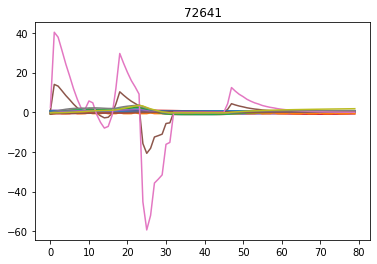

In [20]:
idx = np.random.randint(len(X))
plt.plot(X[idx, len(cat_features):].T)
plt.title(idx)
plt.show()

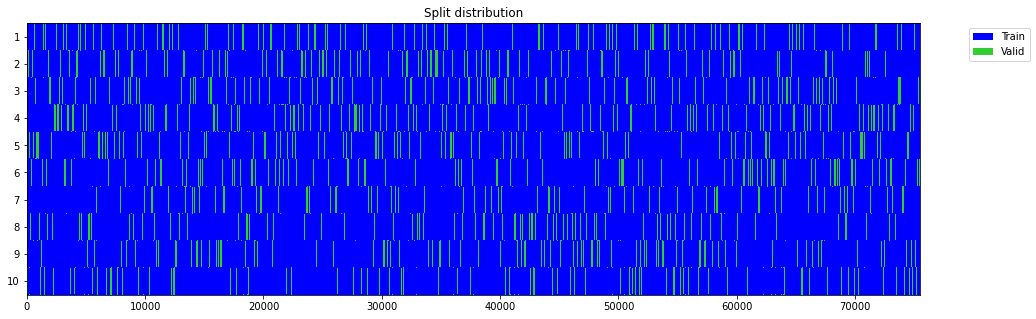

[((#67905) [28053,71264,70070,69997,67789,50216,17349,38825,6183,2258...],
  (#7545) [36862,37370,58818,74068,54622,43804,60376,43969,32746,59136...]),
 ((#67905) [28109,71298,70081,70012,67841,50347,17409,38885,6175,2283...],
  (#7545) [36292,36884,57704,74179,53530,43126,59705,43328,32090,58183...]),
 ((#67905) [28114,71273,70067,70001,67820,50250,17403,38824,6200,2290...],
  (#7545) [36650,37259,58369,73986,54605,43886,59974,44085,32508,58668...]),
 ((#67905) [28056,71265,70042,69973,67798,50197,17364,38764,6220,2297...],
  (#7545) [37378,37986,58939,73866,54848,44691,60626,44900,33160,59340...]),
 ((#67905) [27979,71295,70074,70005,67822,50243,17285,38723,6156,2262...],
  (#7545) [37887,38304,58727,74073,54615,44492,60356,44709,33669,59161...]),
 ((#67905) [28148,71278,70091,70016,67817,50281,17392,38896,6162,2275...],
  (#7545) [36189,36742,58420,74010,54177,43179,60176,43374,31957,58891...]),
 ((#67905) [28027,71329,70117,70046,67847,50324,17378,38797,6233,2281...],
  (#7545) [37

In [21]:
TRAIN_ONLY = False
cv_splits = get_splits(RCs, 10, random_state=23, train_only=TRAIN_ONLY)
splits = cv_splits[0]
train_split, valid_split = splits
beep()
cv_splits

# New code

## Layer

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
        
def trunc_normal_(x, mean=0., std=1.):
    "Truncated normal initialization (approximation)"
    # From fastai.layers
    # From https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/12
    return x.normal_().fmod_(2).mul_(std).add_(mean)

class Embedding(nn.Embedding):
    "Embedding layer with truncated normal initialization"
    # From fastai.layers
    def __init__(self, ni, nf, std=0.01):
        super(Embedding, self).__init__(ni, nf)
        trunc_normal_(self.weight.data, std=std)
        
class MultiEmbedding(Module):
    def __init__(self, n_embeds, embed_dims=None, static=False):
        n_embeds = listify(n_embeds)
        if embed_dims is None: 
            assert not static, "you need to pass an embed_dims as a single int"
            embed_dims = [emb_sz_rule(s) for s in n_embeds]
        else:
            embed_dims = listify(embed_dims)
            if len(embed_dims) == 1: embed_dims = embed_dims * len(n_embeds)
            assert len(embed_dims) == len(n_embeds)
        self.cat_embed = nn.ModuleList([Embedding(n,d) for n,d in zip(n_embeds, embed_dims)])
        self.static, self.embed_dims = static, embed_dims
        self.transpose = Transpose(-1, -2, contiguous=True)

    def forward(self, x):
        if x.ndim == 3: 
            if self.static:
                output =  torch.cat([e(x[:, i, 0].long())[:, None] for i,e in enumerate(self.cat_embed)],1)
                return output
            else: 
                output =  torch.cat([e(x[:,i].long()) for i,e in enumerate(self.cat_embed)],2)
                output = output
                return output
        elif x.ndim == 2:
            assert len(list(set(self.embed_dims))) == 1, "you need to pass embed_dims of type int when using a 2d input"
            output =  torch.cat([e(x[:,i].long())[:, None] for i,e in enumerate(self.cat_embed)],1)
            return self.transpose(output)

## Transformer

### Old

In [23]:
class CustomTransformerv1(Module):
    def __init__(self, c_in:int, c_out:int, seq_len:int, n_layers:int=6, d_model:int=512, n_heads:int=8, d_head:Optional[int]=None, act:str='relu', 
                 d_ff:int=2048, dropout:float=0., pre_norm:bool=False, n_embeds=None, embed_dims=None, cat_pos=None, cont_pos=None, kss=None, maxpool=True,
                 custom_head=None):

        assert cat_pos or cont_pos, "you must pass cat_pos and/or cont_pos"
        if cat_pos: self.cat_pos = cat_pos
        else: self.cat_pos = [p for p in np.arange(c_in) if p not in cont_pos]
        if cont_pos: self.cont_pos = cont_pos
        else: self.cont_pos = [p for p in np.arange(c_in) if p not in cat_pos]
        if embed_dims is None: embed_dims = [emb_sz_rule(s) for s in n_embeds]
        assert d_model > sum(embed_dims)
        if self.cat_pos: 
            self.to_cat_emb = MultiEmbedding(n_embeds, embed_dims=embed_dims)
        if self.cont_pos:
            if kss is None:
                self.conv = Conv1d(len(self.cont_pos), d_model - sum(embed_dims), 1)
            else: 
                self.conv = MultiConcatConv1d(len(self.cont_pos), d_model - sum(embed_dims), kss=kss, maxpool=maxpool)
        self.transpose = Transpose(1,2)

        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, d_model))
        # self.pos_embedding = PositionalEncoding(seq_len, d_model).unsqueeze(0)
        self.pos_dropout = nn.Dropout(dropout)

        self.pre_norm = nn.LayerNorm(d_model) if pre_norm else nn.Identity()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_ff, dropout=dropout, activation=act, 
                                                   layer_norm_eps=1e-05, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.post_norm = nn.LayerNorm(d_model) if not pre_norm else nn.Identity()
        if custom_head:
            if isinstance(custom_head, nn.Module): self.head = custom_head
            else: self.head = custom_head(self.head_nf, c_out, seq_len)
        else: self.head = LinLnDrop(d_model, c_out, p=0)

    def forward(self, x):
        # Embedding
        if self.cat_pos:
            x_cat = self.transpose(self.to_cat_emb(x[:, self.cat_pos].long()))  # cat embedding
        else: 
            x_cat = torch.tensor([], device=x.device)
        if self.cont_pos: 
            x_cont = self.transpose(self.conv(x[:, self.cont_pos]))             # cont feature extraction
        else: 
            x_cont = torch.tensor([], device=x.device)
        x = torch.cat([x_cat, x_cont], -1)

        x = self.pos_dropout(x + self.pos_embedding)
        x = self.pre_norm(x)
        x = self.encoder(x)
        x = self.pre_norm(x)
        x = self.head(x)
        return x

In [24]:
class CustomTransformerv2(Module):
    def __init__(self, c_in:int, c_out:int, seq_len:int, n_layers:int=6, d_model:int=512, n_heads:int=8, d_head:Optional[int]=None, act:str='relu', 
                 d_ff:int=2048, dropout:float=0., n_embeds=None, embed_dims=None, cat_pos=None, cont_pos=None, kss=None, maxpool=True,
                 custom_head=None):

        assert cat_pos or cont_pos, "you must pass cat_pos and/or cont_pos"
        if cat_pos: self.cat_pos = cat_pos
        else: self.cat_pos = [p for p in np.arange(c_in) if p not in cont_pos]
        if cont_pos: self.cont_pos = cont_pos
        else: self.cont_pos = [p for p in np.arange(c_in) if p not in cat_pos]
        if embed_dims is None: embed_dims = [emb_sz_rule(s) for s in n_embeds]
        assert d_model > sum(embed_dims)
        if self.cat_pos: 
            self.to_cat_emb = MultiEmbedding(n_embeds, embed_dims=embed_dims)
        if self.cont_pos:
            if kss is None:
                self.conv = Conv1d(len(self.cont_pos), d_model - sum(embed_dims), 1)
            else: 
                self.conv = MultiConcatConv1d(len(self.cont_pos), d_model - sum(embed_dims), kss=kss, maxpool=maxpool)
        self.transpose = Transpose(1,2)

        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, d_model))
        # self.pos_embedding = PositionalEncoding(seq_len, d_model).unsqueeze(0)
        self.pos_dropout = nn.Dropout(dropout)
        
        self.norm = nn.LayerNorm(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_ff, dropout=dropout, activation=act, 
                                                   layer_norm_eps=1e-05, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        if custom_head:
            if isinstance(custom_head, nn.Module): self.head = custom_head
            else: self.head = custom_head(self.head_nf, c_out, seq_len)
        else: self.head = LinLnDrop(d_model, c_out, p=0)

    def forward(self, x):
        # Embedding
        if self.cat_pos:
            x_cat = self.transpose(self.to_cat_emb(x[:, self.cat_pos].long()))  # cat embedding
        else: 
            x_cat = torch.tensor([], device=x.device)
        if self.cont_pos: 
            x_cont = self.transpose(self.conv(x[:, self.cont_pos]))             # cont feature extraction
        else: 
            x_cont = torch.tensor([], device=x.device)
        x = torch.cat([x_cat, x_cont], -1)

        x = self.pos_dropout(x + self.pos_embedding)
        
        x = self.norm(x)
        x = self.encoder(x)

        x = self.head(x)
        return x

In [25]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        drop_probs = (drop, drop)

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.drop1 = nn.Dropout(drop_probs[0])
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop2 = nn.Dropout(drop_probs[1])

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x


class CustomTransformerv3(Module):
    def __init__(self, c_in:int, c_out:int, seq_len:int, n_layers:int=6, d_model:int=512, n_heads:int=8, d_head:Optional[int]=None, act_layer:nn.Module=None, 
                 dropout:float=0., attn_dropout:float=0., drop_path_rate:float=0, mlp_ratio:int=4, qkv_bias:bool=True,
                 norm_layer:nn.Module=None, n_embeds=None, embed_dims=None, cat_pos=None, cont_pos=None, kss=None, maxpool=True, custom_head=None):

        assert cat_pos or cont_pos, "you must pass cat_pos and/or cont_pos"
        if cat_pos: self.cat_pos = cat_pos
        else: self.cat_pos = [p for p in np.arange(c_in) if p not in cont_pos]
        if cont_pos: self.cont_pos = cont_pos
        else: self.cont_pos = [p for p in np.arange(c_in) if p not in cat_pos]
        if embed_dims is None: embed_dims = [emb_sz_rule(s) for s in n_embeds]
        assert d_model > sum(embed_dims)
        if self.cat_pos: 
            self.to_cat_emb = MultiEmbedding(n_embeds, embed_dims=embed_dims)
        if self.cont_pos:
            if kss is None:
                self.conv = Conv1d(len(self.cont_pos), d_model - sum(embed_dims), 1)
            else: 
                self.conv = MultiConcatConv1d(len(self.cont_pos), d_model - sum(embed_dims), kss=kss, maxpool=maxpool)
        self.transpose = Transpose(1,2)

        self.pos_embed = nn.Parameter(torch.zeros(1, seq_len, d_model))
        with torch.no_grad(): trunc_normal_(self.pos_embed, std=.02)
        self.pos_dropout = nn.Dropout(dropout)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, n_layers)] 
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.blocks = nn.Sequential(*[
            Block(
                dim=d_model, num_heads=n_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, drop=dropout,
                attn_drop=attn_dropout, drop_path=dpr[i], norm_layer=norm_layer, act_layer=act_layer)
            for i in range(n_layers)])
        self.norm = norm_layer(d_model)

        self.head_nf = d_model
        if custom_head:
            if isinstance(custom_head, nn.Module): self.head = custom_head
            else: self.head = custom_head(self.head_nf, c_out, seq_len)
        else: self.head = nn.Linear(self.head_nf, c_out) if c_out > 0 else nn.Identity()

    def forward(self, x):
        # Embedding
        if self.cat_pos:
            x_cat = self.transpose(self.to_cat_emb(x[:, self.cat_pos].long()))  # cat embedding
        else: 
            x_cat = torch.tensor([], device=x.device)
        if self.cont_pos: 
            x_cont = self.transpose(self.conv(x[:, self.cont_pos]))             # cont feature extraction
        else: 
            x_cont = torch.tensor([], device=x.device)
        x = torch.cat([x_cat, x_cont], -1)


        x = self.pos_dropout(x + self.pos_embed)

        x = self.blocks(x)
        x = self.norm(x)

        x = self.head(x)
        return x


# def _init_vit_weights(module: nn.Module, name: str = '', head_bias: float = 0., jax_impl: bool = False):
#     """ ViT weight initialization
#     * When called without n, head_bias, jax_impl args it will behave exactly the same
#       as my original init for compatibility with prev hparam / downstream use cases (ie DeiT).
#     * When called w/ valid n (module name) and jax_impl=True, will (hopefully) match JAX impl
#     """
#     if isinstance(module, nn.Linear):
#         if name.startswith('head'):
#             nn.init.zeros_(module.weight)
#             nn.init.constant_(module.bias, head_bias)
#         elif name.startswith('pre_logits'):
#             lecun_normal_(module.weight)
#             nn.init.zeros_(module.bias)
#         else:
#             if jax_impl:
#                 nn.init.xavier_uniform_(module.weight)
#                 if module.bias is not None:
#                     if 'mlp' in name:
#                         nn.init.normal_(module.bias, std=1e-6)
#                     else:
#                         nn.init.zeros_(module.bias)
#             else:
#                 trunc_normal_(module.weight, std=.02)
#                 if module.bias is not None:
#                     nn.init.zeros_(module.bias)
#     elif jax_impl and isinstance(module, nn.Conv2d):
#         # NOTE conv was left to pytorch default in my original init
#         lecun_normal_(module.weight)
#         if module.bias is not None:
#             nn.init.zeros_(module.bias)
#     elif isinstance(module, (nn.LayerNorm, nn.GroupNorm, nn.BatchNorm2d)):
#         nn.init.zeros_(module.bias)
#         nn.init.ones_(module.weight)

### v4

In [26]:
class CustomTransformerv4(Module):
    def __init__(self, c_in:int, c_out:int, seq_len:int, n_layers:int=6, d_model:int=512, n_heads:int=8, d_head:Optional[int]=None, act:str='relu', use_bn=False,
                 d_ff:int=2048, dropout:float=0., n_embeds=None, embed_dims=None, cat_pos=None, cont_pos=None, kss=None, maxpool=True,
                 custom_head=None):

        assert cat_pos or cont_pos, "you must pass cat_pos and/or cont_pos"
        if cat_pos: self.cat_pos = cat_pos
        else: self.cat_pos = [p for p in np.arange(c_in) if p not in cont_pos]
        if cont_pos: self.cont_pos = cont_pos
        else: self.cont_pos = [p for p in np.arange(c_in) if p not in cat_pos]
        if embed_dims is None: embed_dims = [emb_sz_rule(s) for s in n_embeds]
        assert d_model > sum(embed_dims)
        if self.cat_pos: 
            self.to_cat_emb = MultiEmbedding(n_embeds, embed_dims=embed_dims)

        if kss:
            self.conv = MultiConcatConv1d(len(self.cont_pos) + sum(embed_dims), d_model, kss=kss, maxpool=maxpool)
        else:
            self.conv = Conv1d(len(self.cont_pos) + sum(embed_dims), d_model, 1)
        self.transpose = Transpose(1,2)

        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, d_model))
        # self.pos_embedding = PositionalEncoding(seq_len, d_model).unsqueeze(0)
        self.pos_dropout = nn.Dropout(dropout)
        
        if use_bn: self.norm = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(d_model), Transpose(1,2))
        else: self.norm = nn.LayerNorm(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_ff, dropout=dropout, activation=act, 
                                                   layer_norm_eps=1e-05, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        if custom_head:
            if isinstance(custom_head, nn.Module): self.head = custom_head
            else: self.head = custom_head(self.head_nf, c_out, seq_len)
        else: self.head = LinLnDrop(d_model, c_out, p=0)

    def forward(self, x):
        
        # Embedding
        if self.cat_pos:
            x_cat = self.to_cat_emb(x[:, self.cat_pos].long())  # cat embedding
            x_cat = self.transpose(x_cat)
        else: 
            x_cat = torch.tensor([], device=x.device)
        if self.cont_pos: 
            x_cont = x[:, self.cont_pos]                        # cont features
            
        else: 
            x_cont = torch.tensor([], device=x.device)
        x = torch.cat([x_cat, x_cont], 1)
        
        # Feature extraction
        x = self.conv(x)
        x = self.transpose(x)
        

        # Position embedding
        x = self.pos_dropout(x + self.pos_embedding)
        
        # Encoder
        x = self.norm(x)
        x = self.encoder(x)

        # Head
        x = self.head(x)
        return x

## SpaceTimeFormer

In [27]:
class SpaceTimeFormer(Module):
    def __init__(self, c_in:int, c_out:int, seq_len:int, n_layers:int=6, d_model:int=512, n_heads:int=8, d_head:Optional[int]=None, act:str='relu', 
                 d_ff:int=2048, dropout:float=0., n_embeds=None, embed_dims=None, cat_pos=None, cont_pos=None, kss=None, maxpool=True,
                 custom_head=None):

        assert cat_pos or cont_pos, "you must pass cat_pos and/or cont_pos"
        if cat_pos: self.cat_pos = cat_pos
        else: self.cat_pos = [p for p in np.arange(c_in) if p not in cont_pos]
        if cont_pos: self.cont_pos = cont_pos
        else: self.cont_pos = [p for p in np.arange(c_in) if p not in cat_pos]
        self.cont_pos, self.time_pos = self.cont_pos[:-2], self.cont_pos[-2:]
        if self.cat_pos: 
            self.to_cat_emb = MultiEmbedding(n_embeds, embed_dims=d_model, static=True)
        if self.cont_pos:
            self.to_cont_emb = nn.ModuleList([nn.Linear(3, d_model) for _ in self.cont_pos])
        self.vars = torch.tensor([0,1]+[2]*seq_len+[3]*seq_len).long().to(default_device()).reshape(-1,1)
        self.to_var_emb = MultiEmbedding(c_in, embed_dims=d_model, static=True)

        self.transpose = Transpose(1,2)

        # self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, d_model))
        # # self.pos_embedding = PositionalEncoding(seq_len, d_model).unsqueeze(0)
        # self.pos_dropout = nn.Dropout(dropout)
        
        nf = seq_len * len(self.cont_pos) + len(self.cat_pos)
        self.norm = nn.BatchNorm1d(nf)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_ff, dropout=dropout, activation=act, 
                                                   layer_norm_eps=1e-05, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.lin = nn.Linear(nf, seq_len)
        if custom_head:
            if isinstance(custom_head, nn.Module): self.head = custom_head
            else: self.head = custom_head(self.head_nf, c_out, seq_len)
        else: self.head = LinLnDrop(d_model, c_out, p=0)

    def forward(self, x):
        
        # Embeddings
        if self.cat_pos:
            x_cat = self.to_cat_emb(x[:, self.cat_pos].long())  # cat embedding
            print(x_cat.shape)
        else: 
            x_cat = torch.tensor([], device=x.device)
        if self.cont_pos: 
            for i,l in enumerate(self.to_cont_emb):
                _x_cont = torch.cat([x[:, self.cont_pos[i]][:, None], x[:, self.time_pos]],1)
                _x_cont = l(self.transpose(_x_cont))
                x_cont =  _x_cont if i==0 else torch.cat([x_cont, _x_cont], 1) # cont features
        else: 
            x_cont = torch.tensor([], device=x.device)
        
        x = torch.cat([x_cat, x_cont], 1)

        var_emb = self.to_var_emb(self.vars).permute(2,0,1).expand(x.shape[0],-1,-1)
        x = x + var_emb
        
        # Encoder
        x = self.norm(x)
        x = self.encoder(x)

        x = self.transpose(x)
        x = self.lin(x)
        x = self.transpose(x)

        # Head
        x = self.head(x)
        return x


# try: del dls, learn, model, custom_head; gc.collect()
# except: pass
# _splits = (splits[0][:512], splits[1][:512])
# dls = get_ts_dls(np.random.rand(*X.shape), y_cat, splits=_splits, bs=[64, 512], path=PATH)
# # dls = get_ts_dls(X, y_cat_masked, splits=splits, bs=[64, 512], path=PATH)
# d_model = 128
# custom_head = nn.Sequential(LinLnDrop(d_model, len(i2p), p=0))
# model = SpaceTimeFormer(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=6, n_heads=16, kss=[1,3,5,7,9], maxpool=True,
#                         n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head).cuda()
# model(dls.one_batch()[0]).shape

## InceptionTime

In [28]:
class InceptionTimePlus(nn.Sequential):
    def __init__(self, c_in, c_out, seq_len=None, nf=32, nb_filters=None,
                 flatten=False, concat_pool=False, fc_dropout=0., bn=False, y_range=None, custom_head=None, **kwargs):

        if nb_filters is not None: nf = nb_filters
        else: nf = ifnone(nf, nb_filters) # for compatibility
        backbone = InceptionBlockPlus(c_in, nf, **kwargs)

        #head
        self.head_nf = nf * 4
        self.c_out = c_out
        self.seq_len = seq_len
        if custom_head: 
            if isinstance(custom_head, nn.Module): head = custom_head
            else: head = custom_head(self.head_nf, c_out, seq_len)
        else: head = self.create_head(self.head_nf, c_out, seq_len, flatten=flatten, concat_pool=concat_pool,
                                      fc_dropout=fc_dropout, bn=bn, y_range=y_range)

        layers = OrderedDict([('backbone', nn.Sequential(backbone)), ('head', nn.Sequential(head))])
        super().__init__(layers)

    def create_head(self, nf, c_out, seq_len, flatten=False, concat_pool=False, fc_dropout=0., bn=False, y_range=None):
        if flatten:
            nf *= seq_len
            layers = [Flatten()]
        else:
            if concat_pool: nf *= 2
            layers = [GACP1d(1) if concat_pool else GAP1d(1)]
        layers += [LinBnDrop(nf, c_out, bn=bn, p=fc_dropout)]
        if y_range: layers += [SigmoidRange(*y_range)]
        return nn.Sequential(*layers)

In [29]:
class CustomIT(Module):
    def __init__(self, c_in:int, c_out:int, seq_len:int, d_model=512, n_embeds=None, embed_dims=None, cat_pos=None, cont_pos=None, kss=[3,5,7], maxpool=True,
                 custom_head=None):

        
        self.cat_pos = cat_pos
        self.cont_pos = cont_pos
        if embed_dims is None: embed_dims = [emb_sz_rule(s) for s in n_embeds]
        assert d_model > sum(embed_dims)
        if self.cat_pos: 
            self.to_cat_emb = MultiEmbedding(n_embeds, embed_dims=embed_dims)
        if self.cont_pos:
            self.conv = MultiConcatConv1d(len(cont_pos), d_model - sum(embed_dims), kss=kss, maxpool=maxpool)
        self.transpose = Transpose(1,2)

        self.it = InceptionTimePlus(d_model, c_out, seq_len, custom_head=custom_head, nf=128)



    def forward(self, x):
        # Embedding
        if self.cat_pos:
            x_cat = self.to_cat_emb(x[:, self.cat_pos].long())  # cat embedding
        else: 
            x_cat = torch.tensor([], device=x.device)
        if self.cont_pos: 
            x_cont = self.conv(x[:, self.cont_pos])             # cont feature extraction
        else: 
            x_cont = torch.tensor([], device=x.device)
        x = torch.cat([x_cat, x_cont], 1)
        x = self.it(x)
        return x

## LSTM

In [30]:
class CustomLSTM(nn.Module):
    def __init__(self, c_in, c_out, seq_len, hidden_size=[100], bidirectional=True, n_embeds=None, embed_dims=None, cat_pos=None, cont_pos=None, 
                 rnn_dropout=0, bias=True, kss=None, maxpool=True, custom_head=None):
        super().__init__()

        hidden_size = listify(hidden_size)
        self.cat_pos = cat_pos
        self.cont_pos = cont_pos
        if embed_dims is None: embed_dims = [emb_sz_rule(s) for s in n_embeds]
        assert hidden_size[0] > sum(embed_dims)
        self.to_cat_emb = MultiEmbedding(n_embeds, embed_dims=embed_dims)
        self.transpose = Transpose(1,2)

        if kss is not None:
            self.conv = MultiConcatConv1d(len(cont_pos), hidden_size[0] - sum(embed_dims), kss=kss, maxpool=maxpool)
        else: 
            self.conv = nn.Identity()
        
        # RNN
        hidden_size = listify(hidden_size)
        if len(set(hidden_size)) == 1:
            n_layers = len(hidden_size)
            n_layers = max(len(hidden_size), n_layers)
            self.rnn = nn.Sequential(nn.LSTM(hidden_size[0], hidden_size[0], num_layers=n_layers, bias=bias, batch_first=True, dropout=rnn_dropout, 
                                             bidirectional=bidirectional), LSTMOutput())
        else:
            layers = []
            for i in range(len(hidden_size)):
                input_size = hidden_size[0] if i == 0 else hs * (1 + bidirectional)
                hs = hidden_size[i]
                layers.append(nn.LSTM(input_size, hs, num_layers=1, bias=bias, batch_first=True, dropout=rnn_dropout, bidirectional=bidirectional))
                layers.append(LSTMOutput()) # this selects just the output, and discards h_n, and c_n
            self.rnn = nn.Sequential(*layers)

        # Head
        self.head_nf = hidden_size[-1] * (1 + bidirectional)
        if custom_head:
            if isinstance(custom_head, nn.Module): self.head = custom_head
            else: self.head = custom_head(self.head_nf, c_out, seq_len) # custom head must have all required kwargs
        else: self.head = nn.Sequential(Transpose(1,2), nn.Linear(self.head_nf, c_out))

        # initialization
        self.apply(self._weights_init)

    def forward(self, x):

        # Embeddings
        if self.cat_pos:
            x_cat = self.transpose(self.to_cat_emb(x[:, self.cat_pos].long()))  # cat embedding
        else: 
            x_cat = torch.tensor([], device=x.device)
        if self.cont_pos: 
            x_cont = self.transpose(self.conv(x[:, self.cont_pos]))             # cont feature extraction
        else: 
            x_cont = torch.tensor([], device=x.device)
        x = torch.cat([x_cat, x_cont], -1)

        x = self.rnn(x)
        x = self.transpose(x)
        x = self.head(x)
        return x

    def _weights_init(self, m):
        if isinstance(m, (nn.LSTM, nn.GRU)): # same init as keras
            nn.init.xavier_uniform_(m.weight_ih_l0)
            nn.init.orthogonal_(m.weight_hh_l0)
            if hasattr(m, "weight_ih_l0_reverse"): nn.init.xavier_uniform_(m.weight_ih_l0_reverse)
            if hasattr(m, "weight_hh_l0_reverse"): nn.init.orthogonal_(m.weight_hh_l0_reverse)

In [31]:
class CustomLSTMv4(nn.Module):
    def __init__(self, c_in, c_out, seq_len, hidden_size=[100], bidirectional=True, n_embeds=None, embed_dims=None, cat_pos=None, cont_pos=None, 
                 rnn_dropout=0, bias=True, kss=None, maxpool=True, custom_head=None):
        super().__init__()

        hidden_size = listify(hidden_size)
        self.cat_pos = cat_pos
        self.cont_pos = cont_pos
        if embed_dims is None: embed_dims = [emb_sz_rule(s) for s in n_embeds]
        assert hidden_size[0] > sum(embed_dims)
        self.to_cat_emb = MultiEmbedding(n_embeds, embed_dims=embed_dims)
        self.transpose = Transpose(1,2)

        self.conv = MultiConcatConv1d(len(cont_pos) + sum(embed_dims), hidden_size[0], kss=kss, maxpool=maxpool)
        
        # RNN
        hidden_size = listify(hidden_size)
        if len(set(hidden_size)) == 1:
            n_layers = len(hidden_size)
            n_layers = max(len(hidden_size), n_layers)
            self.rnn = nn.Sequential(nn.LSTM(hidden_size[0], hidden_size[0], num_layers=n_layers, bias=bias, batch_first=True, dropout=rnn_dropout, 
                                             bidirectional=bidirectional), LSTMOutput())
        else:
            layers = []
            for i in range(len(hidden_size)):
                input_size = hidden_size[0] if i == 0 else hs * (1 + bidirectional)
                hs = hidden_size[i]
                layers.append(nn.LSTM(input_size, hs, num_layers=1, bias=bias, batch_first=True, dropout=rnn_dropout, bidirectional=bidirectional))
                layers.append(LSTMOutput()) # this selects just the output, and discards h_n, and c_n
            self.rnn = nn.Sequential(*layers)

        # Head
        self.head_nf = hidden_size[-1] * (1 + bidirectional)
        if custom_head:
            if isinstance(custom_head, nn.Module): self.head = custom_head
            else: self.head = custom_head(self.head_nf, c_out, seq_len) # custom head must have all required kwargs
        else: self.head = nn.Sequential(Transpose(1,2), nn.Linear(self.head_nf, c_out))

        # initialization
        self.apply(self._weights_init)

    def forward(self, x):

        # Embeddings
        if self.cat_pos:
            x_cat = self.to_cat_emb(x[:, self.cat_pos].long())  # cat embedding
        else: 
            x_cat = torch.tensor([], device=x.device)
        if self.cont_pos: 
            x_cont = x[:, self.cont_pos]             # cont feature extraction
        else: 
            x_cont = torch.tensor([], device=x.device)
        x = torch.cat([x_cat, x_cont], 1)

        x = self.conv(x)
        x = self.transpose(x)
        
        x = self.rnn(x)
        x = self.transpose(x)
        x = self.head(x)
        return x

    def _weights_init(self, m):
        if isinstance(m, (nn.LSTM, nn.GRU)): # same init as keras
            nn.init.xavier_uniform_(m.weight_ih_l0)
            nn.init.orthogonal_(m.weight_hh_l0)
            if hasattr(m, "weight_ih_l0_reverse"): nn.init.xavier_uniform_(m.weight_ih_l0_reverse)
            if hasattr(m, "weight_hh_l0_reverse"): nn.init.orthogonal_(m.weight_hh_l0_reverse)

## CutMix

In [32]:
from torch.distributions.beta import Beta

# Cell
def _reduce_loss(loss, reduction='mean'):
    "Reduce the loss based on `reduction`"
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss

# Cell
class MixHandler1d(Callback):
    "A handler class for implementing mixed sample data augmentation"
    run_valid = False

    def __init__(self, alpha=0.5, update_seq=True):
        self.distrib = Beta(alpha, alpha)
        self.update_seq = update_seq

    def before_train(self):
        self.labeled = True if self.dls.d != 0 else False
        if self.labeled and not self.update_seq:
            self.stack_y = getattr(self.learn.loss_func, 'y_int', False)
            if self.stack_y: self.old_lf, self.learn.loss_func = self.learn.loss_func, self.lf
        else: self.stack_y = False

    def after_train(self):
        if self.labeled and self.stack_y: self.learn.loss_func = self.old_lf

    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf: loss = torch.lerp(lf(pred, *self.yb1), lf(pred, *yb), self.lam)
        return _reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))

# Cell
class CutMix1d(MixHandler1d):
    "Implementation of `https://arxiv.org/abs/1905.04899`"

    def __init__(self, alpha=1., update_seq=True):
        super().__init__(alpha, update_seq)

    def before_batch(self):
        bs, *_, seq_len = self.x.size()
        self.lam = self.distrib.sample((1, ))
        shuffle = torch.randperm(bs)
        xb1 = self.x[shuffle]
        x1, x2 = self.rand_bbox(seq_len, self.lam)
        self.learn.xb[0][..., x1:x2] = xb1[..., x1:x2]
        self.lam = (1 - (x2 - x1) / float(seq_len)).item()
        if self.labeled:
            if self.update_seq: 
                self.learn.yb[0][..., x1:x2] = self.y[shuffle, ..., x1:x2]
            else:
                self.yb1 = tuple((self.y[shuffle], ))
                if not self.stack_y:
                    self.learn.yb = tuple(L(self.yb1, self.yb).map_zip(torch.lerp, weight=unsqueeze(self.lam, n=self.y.ndim - 1)))

    def rand_bbox(self, seq_len, lam):
        cut_rat = torch.sqrt(1. - lam)
        cut_seq_len = torch.round(seq_len * cut_rat).type(torch.long)

        # uniform
        cx = torch.randint(0, seq_len, (1, ))
        x1 = torch.clamp(cx - cut_seq_len // 2, 0, seq_len)
        x2 = torch.clamp(cx + cut_seq_len // 2, 0, seq_len)
        return x1, x2

CutMix1D = CutMix1d

## Loss

In [33]:
class OrdinalLoss(Module):
    def __init__(self, c_out):
        store_attr()
        self.range = torch.arange(c_out).reshape(1, 1, -1).to(default_device())

    def forward(self, inp, targ):
        inp = F.softmax(inp, -1)
        w = torch.abs(targ[..., None] - self.range)
        return (inp * w).sum(-1).mean()

In [34]:
class MaskedLoss(Module):
    def __init__(self, crit):
        self.crit = crit
    def forward(self, inp, targ):
        mask = targ >= 0
        inp = inp[mask]
        targ = targ[mask]
        return self.crit(inp, targ)

## BSLR Managers

In [35]:
class ReduceLROnPlateauWithWarmup(TrackerCallback):
    "A `TrackerCallback` that reduces learning rate when a metric has stopped improving."
    order=TrackerCallback.order+2
    def __init__(self, monitor='valid_loss', comp=None, min_delta=0., patience=1, factor=10., min_lr=0, reset_on_fit=True, warmup=.1, div=25, max_div=1e5):
        super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
        self.patience,self.factor,self.min_lr,self.warmup,self.div,self.max_div = patience,factor,min_lr,warmup,div,max_div

    def before_fit(self): 
        self.wait = 0; super().before_fit()
        if self.min_lr: self.min_lr = self.learn.lr / max_div
    def before_batch(self):
        if self.training and self.pct_train <= self.warmup: 
            for h in self.opt.hypers: 
                old_lr = self.opt.hypers[-1]['lr']
                # h['lr'] = self.learn.lr / (self.div + (1 + math.cos(math.pi*(1-self.pct_train/self.warmup))) * (1-self.div) / 2)
                h['lr'] = self.learn.lr / (self.div + self.pct_train/self.warmup*(1-self.div))
                # print(f'Before batch Epoch {self.epoch}: lr {old_lr} --> {self.opt.hypers[-1]["lr"]}')
    def after_epoch(self):
        "Compare the value monitored to its best score and reduce LR by `factor` if no improvement."
        super().after_epoch()
        if self.new_best: self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = self.opt.hypers[-1]['lr']
                for h in self.opt.hypers: h['lr'] = max(h['lr'] / self.factor, self.min_lr)
                self.wait = 0
                if self.opt.hypers[-1]["lr"] < old_lr:
                    print(f'Epoch {self.epoch}: lr {old_lr} --> {self.opt.hypers[-1]["lr"]}')

In [36]:
# from typing import Callable
# class BatchSizeScheduler(Callback):
#     "Updates batch size during training according to a schedule function"
#     order =60
#     def __init__(self, bss:tuple, sched_fn:Callable, mult:int=4, verbose:bool=True):
#         self.bss = sorted(bss)
#         self.sched_fn, self.mult, self.verbose = sched_fn, mult, verbose

#     def before_epoch(self):
#         bs = round(self.sched_fn(self.pct_train) * (self.bss[1] - self.bss[0]) + self.bss[0])
#         if self.mult: bs = bs // self.mult * self.mult
#         if bs != self.learn.dls.train.bs:
#             pv(f"epoch:{self.epoch:4} - bs:{self.learn.dls.train.bs:4} --> {bs:4}", self.verbose)
#             self.learn.dls.train.bs = bs

In [37]:
from typing import Callable
class BatchSizeScheduler(Callback):
    "Updates batch size during training according to a schedule function"
    order =60
    def __init__(self, bss:list, verbose:bool=True):
        store_attr()

    def before_fit(self):
        self.run = not hasattr(self, "lr_finder") and not hasattr(self, "gather_preds")
        if self.run: 
            assert len(self.bss) == self.learn.n_epoch

    def before_epoch(self):
        if self.run:
            bs = self.bss[self.epoch]
            if bs != self.learn.dls.train.bs:
                pv(f"epoch:{self.epoch:4} - bs:{self.learn.dls.train.bs:4} --> {bs:4}", self.verbose)
                self.learn.dls.train.bs = bs

# Experiments 30/10/21

In [ ]:
# TO TEST
# new features p4, p5

#parameters:29418784


epoch,train_loss,train_cat_mae,train_masked_accuracy,valid_loss,valid_cat_mae,valid_masked_accuracy,time
0,4.322273,2.186859,0.029533,4.345756,1.589481,0.036912,05:32
1,3.930709,1.162054,0.047371,3.907210,0.933040,0.053975,05:34
2,3.752638,0.942186,0.057993,3.804069,0.961431,0.063850,05:34
3,3.717951,0.829725,0.067672,3.636465,0.750305,0.064558,05:33
4,3.581166,0.762276,0.073696,3.521376,0.669757,0.075670,05:33
5,3.452436,0.705890,0.078595,3.413365,0.603889,0.083388,05:32
6,3.357658,0.634194,0.085318,3.363292,0.581732,0.086815,05:31
7,3.248896,0.567948,0.092903,3.236848,0.509848,0.095959,05:35
8,3.167052,0.501879,0.101413,3.234749,0.560666,0.099317,05:31
9,3.025276,0.448202,0.110439,3.015395,0.408959,0.113577,05:30


Better model found at epoch 0 with valid_cat_mae value: 1.5894810573913318.


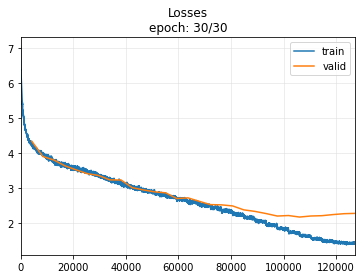

Better model found at epoch 1 with valid_cat_mae value: 0.9330399897468469.
Better model found at epoch 3 with valid_cat_mae value: 0.7503054536418624.
Better model found at epoch 4 with valid_cat_mae value: 0.6697574211290088.
Better model found at epoch 5 with valid_cat_mae value: 0.6038890874901482.
Better model found at epoch 6 with valid_cat_mae value: 0.5817321472805563.
Better model found at epoch 7 with valid_cat_mae value: 0.5098477742647631.
Better model found at epoch 9 with valid_cat_mae value: 0.40895915564471075.
Better model found at epoch 10 with valid_cat_mae value: 0.37077094410077904.
Better model found at epoch 11 with valid_cat_mae value: 0.35854482370399304.
Better model found at epoch 13 with valid_cat_mae value: 0.29763618901624517.
Better model found at epoch 14 with valid_cat_mae value: 0.29166844992735874.
Better model found at epoch 15 with valid_cat_mae value: 0.26975111915516564.
Better model found at epoch 16 with valid_cat_mae value: 0.25787542573307254.

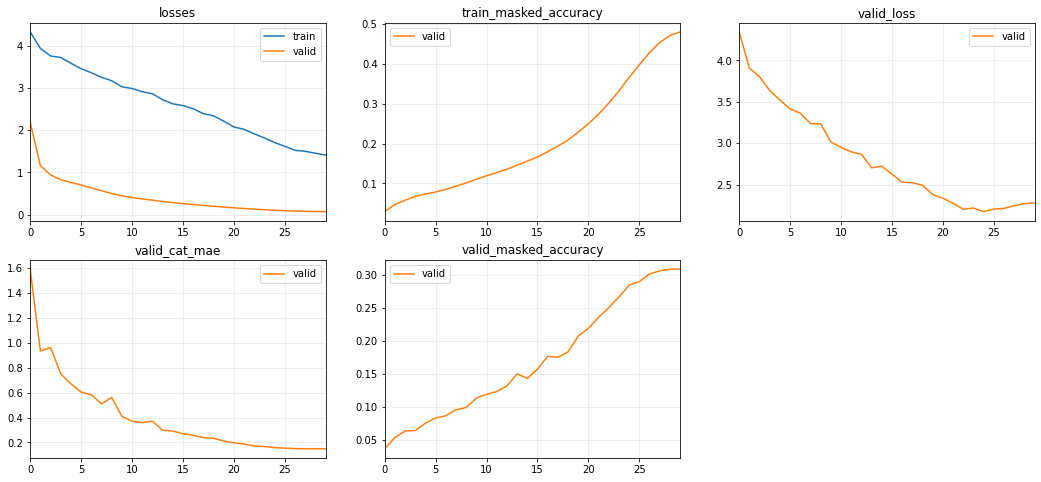

In [43]:
# n_layers
try: del dls, learn, model, custom_head; gc.collect()
except: pass
# _splits = (splits[0][:100], splits[1][:100])
dls = get_ts_dls(X, y_cat_masked, splits=splits, bs=[16, 512], path=PATH)
d_model = 512
custom_head = nn.Sequential(LinLnDrop(d_model, len(i2p), p=0))
model = CustomTransformerv4(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=9, n_heads=16, kss=[1,3,5,7,9], maxpool=True, 
                            n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)

cbs=[ShowGraph(), 
     SaveModelCallback(fname="311021_02C", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, loss_func=MaskedLoss(CrossEntropyLossFlat()), metrics=[cat_mae, masked_accuracy], cbs=cbs)
print(f"#parameters:{count_parameters(learn.model)}")
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit_one_cycle(30, 3e-4)
learn.export("models/311021_02C.pkl")

In [ ]:
# epoch train_loss 	train_mae   train_ac 	valid_loss 	valid_mae 	valid_acc 	time
# 0 	4.260264 	2.149920 	0.029436 	4.248360 	1.506374 	0.039717 	03:27
# 1 	3.959587 	1.203586 	0.046779 	3.960199 	1.045339 	0.052473 	03:25
# 2 	3.766059 	0.949116 	0.058475 	3.761620 	0.834109 	0.063697 	03:26
# 3 	3.695286 	0.814346 	0.068195 	3.669940 	0.805856 	0.066451 	03:25
# 4 	3.510816 	0.745751 	0.074833 	3.490215 	0.652529 	0.077079 	03:26
# 5 	3.476256 	0.696778 	0.079182 	3.533328 	0.701065 	0.078323 	03:26
# 6 	3.378575 	0.638005 	0.084343 	3.353053 	0.568090 	0.087643 	03:26
# 7 	3.255218 	0.568570 	0.091738 	3.332196 	0.615876 	0.090886 	03:26
# 8 	3.147217 	0.511248 	0.099835 	3.150216 	0.515197 	0.103677 	03:26
# 9 	3.018197 	0.456078 	0.107900 	3.097815 	0.444105 	0.108383 	03:28
# 10 	2.979063 	0.417294 	0.115962 	2.950258 	0.391802 	0.119871 	03:28
# 11 	2.907335 	0.381127 	0.124681 	2.903902 	0.364759 	0.125201 	03:28
# 12 	2.862018 	0.349985 	0.132242 	2.882292 	0.351538 	0.126732 	03:27
# 13 	2.721906 	0.325450 	0.141040 	2.820772 	0.326064 	0.134574 	03:27
# 14 	2.692635 	0.296872 	0.150801 	2.719628 	0.299557 	0.147052 	03:27
# 15 	2.586166 	0.273992 	0.162160 	2.658207 	0.294286 	0.158924 	03:28
# 16 	2.485956 	0.250460 	0.173328 	2.586167 	0.256645 	0.163901 	03:27
# 17 	2.434327 	0.228498 	0.186832 	2.540273 	0.253445 	0.174164 	03:28
# 18 	2.330199 	0.208439 	0.202241 	2.450301 	0.225563 	0.189742 	03:27
# 19 	2.277951 	0.188619 	0.219185 	2.373221 	0.212184 	0.204512 	03:27
# 20 	2.181256 	0.170680 	0.239287 	2.350054 	0.197648 	0.208104 	03:28
# 21 	2.057689 	0.153565 	0.263007 	2.298468 	0.188091 	0.227067 	03:28
# 22 	1.995670 	0.138417 	0.287888 	2.222361 	0.174849 	0.247115 	03:27
# 23 	1.898342 	0.124169 	0.317138 	2.216776 	0.169759 	0.257301 	03:27
# 24 	1.788390 	0.112258 	0.345521 	2.221907 	0.164460 	0.263122 	03:31
# 25 	1.700794 	0.102051 	0.376291 	2.214509 	0.159401 	0.277340 	03:32
# 26 	1.623733 	0.093381 	0.404102 	2.236072 	0.156982 	0.284692 	03:33
# 27 	1.561218 	0.087085 	0.426280 	2.257719 	0.156290 	0.289731 	03:33
# 28 	1.511937 	0.083265 	0.441878 	2.263315 	0.154710 	0.293022 	03:33
# 29 	1.520298 	0.081143 	0.450201 	2.268333 	0.154771 	0.293489 	03:33

#parameters:19961632


epoch,train_loss,train_cat_mae,train_masked_accuracy,valid_loss,valid_cat_mae,valid_masked_accuracy,time
0,4.275621,2.261014,0.029307,4.292793,1.224832,0.039810,03:59
1,3.942345,1.164733,0.046812,3.903392,1.011024,0.052805,03:58
2,3.768080,0.927218,0.058567,3.687938,0.790001,0.065845,03:58
3,3.615159,0.804127,0.068683,3.609356,0.766256,0.072292,04:01
4,3.557499,0.747664,0.074090,3.504012,0.658455,0.075199,04:02
5,3.517295,0.696766,0.079242,3.535394,0.748301,0.075538,04:01
6,3.387072,0.634245,0.084945,3.374682,0.588630,0.084841,04:01
7,3.257689,0.565238,0.092507,3.238155,0.539203,0.096574,04:01
8,3.170806,0.501185,0.101066,3.117241,0.466443,0.105616,04:00
9,3.080429,0.454241,0.108992,3.098491,0.443499,0.107436,03:59


Better model found at epoch 0 with valid_cat_mae value: 1.2248320961479946.


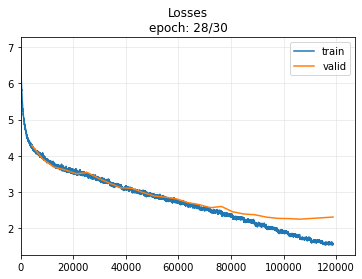

Better model found at epoch 1 with valid_cat_mae value: 1.011023784654895.
Better model found at epoch 2 with valid_cat_mae value: 0.790000624376387.
Better model found at epoch 3 with valid_cat_mae value: 0.7662563395995554.
Better model found at epoch 4 with valid_cat_mae value: 0.6584549874467883.
Better model found at epoch 6 with valid_cat_mae value: 0.5886299266610422.
Better model found at epoch 7 with valid_cat_mae value: 0.5392031362669001.
Better model found at epoch 8 with valid_cat_mae value: 0.46644332654786086.
Better model found at epoch 9 with valid_cat_mae value: 0.44349875397129396.
Better model found at epoch 10 with valid_cat_mae value: 0.40595460785053367.
Better model found at epoch 11 with valid_cat_mae value: 0.3648961815316538.
Better model found at epoch 12 with valid_cat_mae value: 0.35094463723976105.
Better model found at epoch 13 with valid_cat_mae value: 0.32508031550987515.
Better model found at epoch 14 with valid_cat_mae value: 0.29862023245850733.
Bet

KeyboardInterrupt: ignored

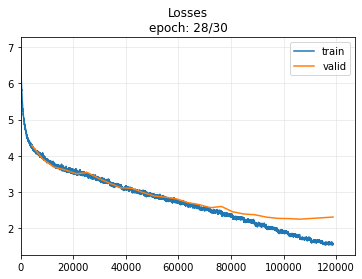

In [41]:
# weight decay
try: del dls, learn, model, custom_head; gc.collect()
except: pass
# _splits = (splits[0][:100], splits[1][:100])
dls = get_ts_dls(X, y_cat_masked, splits=splits, bs=[16, 512], path=PATH)
d_model = 512
custom_head = nn.Sequential(LinLnDrop(d_model, len(i2p), p=0))
model = CustomTransformerv4(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=6, n_heads=16, kss=[1,3,5,7,9], maxpool=True,
                            n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)

cbs=[ShowGraph(), 
     SaveModelCallback(fname="311021_02C", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, loss_func=MaskedLoss(CrossEntropyLossFlat()), metrics=[cat_mae, masked_accuracy], cbs=cbs)
print(f"#parameters:{count_parameters(learn.model)}")
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit_one_cycle(30, 3e-4, wd=1e-3)
learn.export("models/311021_02C.pkl")

#parameters:19961632


epoch,train_loss,train_cat_mae,train_masked_accuracy,valid_loss,valid_cat_mae,valid_masked_accuracy,time
0,4.260264,2.149920,0.029436,4.248360,1.506374,0.039717,03:27
1,3.959587,1.203586,0.046779,3.960199,1.045339,0.052473,03:25
2,3.766059,0.949116,0.058475,3.761620,0.834109,0.063697,03:26
3,3.695286,0.814346,0.068195,3.669940,0.805856,0.066451,03:25
4,3.510816,0.745751,0.074833,3.490215,0.652529,0.077079,03:26
5,3.476256,0.696778,0.079182,3.533328,0.701065,0.078323,03:26
6,3.378575,0.638005,0.084343,3.353053,0.568090,0.087643,03:26
7,3.255218,0.568570,0.091738,3.332196,0.615876,0.090886,03:26
8,3.147217,0.511248,0.099835,3.150216,0.515197,0.103677,03:26
9,3.018197,0.456078,0.107900,3.097815,0.444105,0.108383,03:28


Better model found at epoch 0 with valid_cat_mae value: 1.5063744966527357.


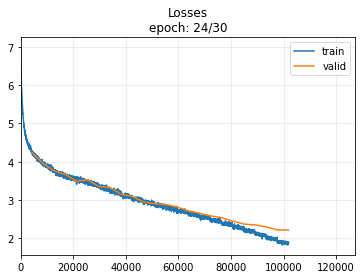

Better model found at epoch 1 with valid_cat_mae value: 1.045339476734189.
Better model found at epoch 2 with valid_cat_mae value: 0.8341090537492658.
Better model found at epoch 3 with valid_cat_mae value: 0.8058558387645384.
Better model found at epoch 4 with valid_cat_mae value: 0.6525288086919906.
Better model found at epoch 6 with valid_cat_mae value: 0.5680900456374888.
Better model found at epoch 8 with valid_cat_mae value: 0.5151969610975281.
Better model found at epoch 9 with valid_cat_mae value: 0.4441050869917371.
Better model found at epoch 10 with valid_cat_mae value: 0.3918016856860192.
Better model found at epoch 11 with valid_cat_mae value: 0.3647585612007303.
Better model found at epoch 12 with valid_cat_mae value: 0.35153827585486896.
Better model found at epoch 13 with valid_cat_mae value: 0.32606380378079125.
Better model found at epoch 14 with valid_cat_mae value: 0.2995566748420242.
Better model found at epoch 15 with valid_cat_mae value: 0.2942855467531345.
Bette

epoch,train_loss,train_cat_mae,train_masked_accuracy,valid_loss,valid_cat_mae,valid_masked_accuracy,time
0,4.260264,2.149920,0.029436,4.248360,1.506374,0.039717,03:27
1,3.959587,1.203586,0.046779,3.960199,1.045339,0.052473,03:25
2,3.766059,0.949116,0.058475,3.761620,0.834109,0.063697,03:26
3,3.695286,0.814346,0.068195,3.669940,0.805856,0.066451,03:25
4,3.510816,0.745751,0.074833,3.490215,0.652529,0.077079,03:26
5,3.476256,0.696778,0.079182,3.533328,0.701065,0.078323,03:26
6,3.378575,0.638005,0.084343,3.353053,0.568090,0.087643,03:26
7,3.255218,0.568570,0.091738,3.332196,0.615876,0.090886,03:26
8,3.147217,0.511248,0.099835,3.150216,0.515197,0.103677,03:26
9,3.018197,0.456078,0.107900,3.097815,0.444105,0.108383,03:28


Better model found at epoch 24 with valid_cat_mae value: 0.16446008677431.


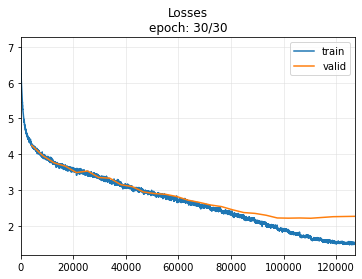

Better model found at epoch 25 with valid_cat_mae value: 0.1594010044356751.
Better model found at epoch 26 with valid_cat_mae value: 0.15698160260694818.
Better model found at epoch 27 with valid_cat_mae value: 0.15629045453408816.
Better model found at epoch 28 with valid_cat_mae value: 0.1547103121877971.


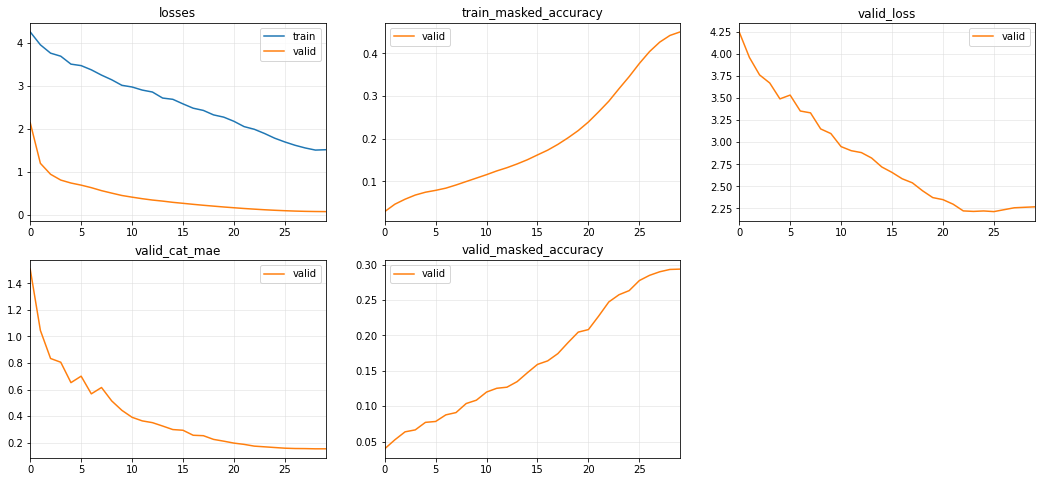

In [38]:
try: del dls, learn, model, custom_head; gc.collect()
except: pass
# _splits = (splits[0][:100], splits[1][:100])
dls = get_ts_dls(X, y_cat_masked, splits=splits, bs=[16, 512], path=PATH)
d_model = 512
custom_head = nn.Sequential(LinLnDrop(d_model, len(i2p), p=0))
model = CustomTransformerv4(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=6, n_heads=16, kss=[1,3,5,7,9], maxpool=True,
                            n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)

cbs=[ShowGraph(), 
     SaveModelCallback(fname="301021_02C", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, loss_func=MaskedLoss(CrossEntropyLossFlat()), metrics=[cat_mae, masked_accuracy], cbs=cbs)
print(f"#parameters:{count_parameters(learn.model)}")
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit_one_cycle(30, 3e-4)
learn.export("models/301021_02C.pkl")

#parameters:19961632


epoch,train_loss,train_cat_mae,train_masked_accuracy,valid_loss,valid_cat_mae,valid_masked_accuracy,time
0,4.958636,4.161732,0.017510,4.928950,2.065333,0.026004,02:43
1,4.301226,1.530126,0.033219,4.266302,1.315443,0.040260,02:43
2,4.024867,1.268795,0.044074,4.008978,1.023959,0.049483,02:43
3,3.799434,1.017266,0.053613,3.803466,0.891070,0.057600,02:43
4,3.659746,0.840839,0.063267,3.641697,0.738380,0.066765,02:43
5,3.484703,0.719845,0.073499,3.486597,0.657789,0.075832,02:44
6,3.386837,0.624405,0.084090,3.462338,0.659457,0.080986,02:43
7,3.228806,0.547554,0.094982,3.243600,0.506300,0.092463,02:43
8,3.149093,0.482142,0.105152,3.105232,0.460730,0.106592,02:43
9,3.005018,0.434422,0.115237,3.112225,0.457768,0.107478,02:43


Better model found at epoch 0 with valid_cat_mae value: 2.0653325956998567.


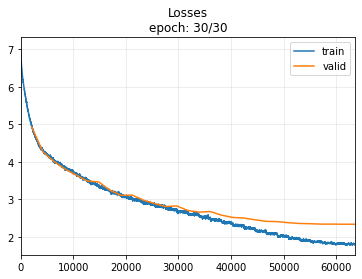

Better model found at epoch 1 with valid_cat_mae value: 1.3154427941990143.
Better model found at epoch 2 with valid_cat_mae value: 1.0239593727081777.
Better model found at epoch 3 with valid_cat_mae value: 0.8910696463325208.
Better model found at epoch 4 with valid_cat_mae value: 0.7383800356969034.
Better model found at epoch 5 with valid_cat_mae value: 0.6577891247257628.
Better model found at epoch 7 with valid_cat_mae value: 0.506300462263221.
Better model found at epoch 8 with valid_cat_mae value: 0.4607298710848378.
Better model found at epoch 9 with valid_cat_mae value: 0.4577676237650506.
Better model found at epoch 10 with valid_cat_mae value: 0.4004795369681963.
Better model found at epoch 11 with valid_cat_mae value: 0.3595721431050051.
Better model found at epoch 12 with valid_cat_mae value: 0.33317030844042245.
Better model found at epoch 14 with valid_cat_mae value: 0.2918595214058152.
Better model found at epoch 15 with valid_cat_mae value: 0.2880291440555367.
Better 

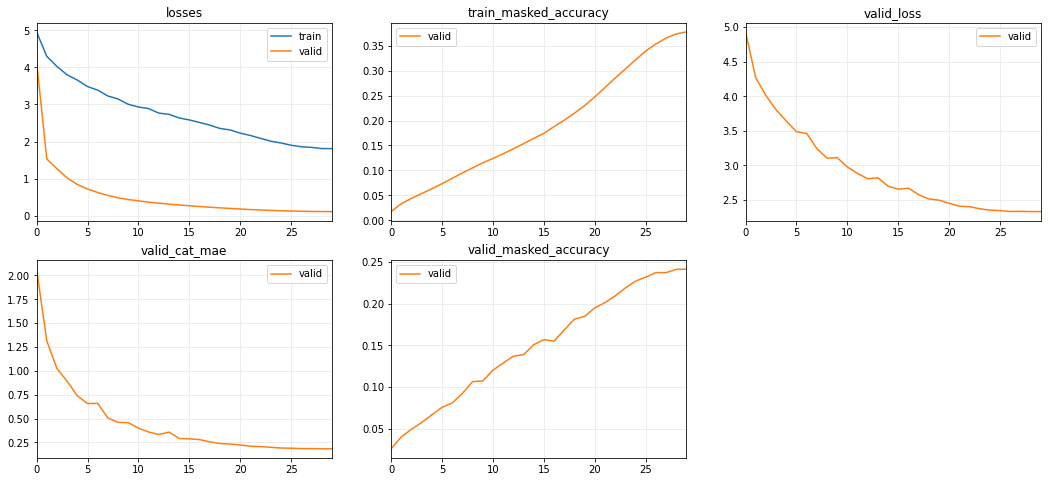

In [41]:
try: del dls, learn, model, custom_head; gc.collect()
except: pass
# _splits = (splits[0][:100], splits[1][:100])
dls = get_ts_dls(X, y_cat_masked, splits=splits, bs=[32, 512], path=PATH)
d_model = 512
custom_head = nn.Sequential(LinLnDrop(d_model, len(i2p), p=0))
model = CustomTransformerv4(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=6, n_heads=16, kss=[1,3,5,7,9], maxpool=True,
                            n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)

cbs=[ShowGraph(), 
     SaveModelCallback(fname="301021_02C", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, loss_func=MaskedLoss(CrossEntropyLossFlat()), metrics=[cat_mae, masked_accuracy], cbs=cbs)
print(f"#parameters:{count_parameters(learn.model)}")
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit_one_cycle(30, 1e-4)
learn.export("models/301021_02C.pkl")

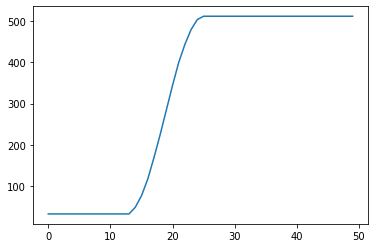

In [40]:
n_epochs = 50
# sched_fn = combine_scheds([.1, .4, .5], [SchedLin(0.,0.), SchedCos(0.,1.), SchedLin(1.,1.)])
sched_fn = combine_scheds([.25, .25, .5], [SchedLin(0.,0.), SchedCos(0.,1.), SchedLin(1.,1.)])
bs_range = [32, 512]
bss = []

mult = 4
for epoch in range(n_epochs):
    bs = round(sched_fn(epoch/n_epochs) * (bs_range[1] - bs_range[0]) + bs_range[0])
    bs = bs // mult * mult
    bss.append(bs)
plt.plot(bss);

#parameters:19961632


epoch,train_loss,train_cat_mae,train_masked_accuracy,valid_loss,valid_cat_mae,valid_masked_accuracy,time
0,3.815548,1.551214,0.043669,3.821679,0.932728,0.060511,02:49
1,3.447148,0.710651,0.073104,3.430383,0.605952,0.081532,02:47
2,3.266282,0.553721,0.090610,3.154706,0.468722,0.100673,02:47
3,3.142634,0.480215,0.102723,3.205971,0.519495,0.097225,02:47
4,3.071561,0.427748,0.114197,3.068121,0.414536,0.106327,02:47
5,2.954878,0.392152,0.123311,2.944548,0.392040,0.121307,02:48
6,2.874046,0.365397,0.131614,2.907123,0.356103,0.123373,02:48
7,2.804679,0.340512,0.139886,2.812753,0.346560,0.139762,02:48
8,2.751393,0.320891,0.147615,2.722646,0.300682,0.148476,02:48
9,2.681499,0.300526,0.156033,2.806397,0.323283,0.139870,02:48


epoch:   0 - bs: 512 -->   32
Better model found at epoch 0 with valid_cat_mae value: 0.9327275366015222.


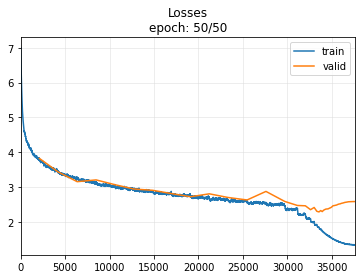

Better model found at epoch 1 with valid_cat_mae value: 0.6059516407204468.
Better model found at epoch 2 with valid_cat_mae value: 0.46872156753236144.
Better model found at epoch 4 with valid_cat_mae value: 0.4145358441574182.
Better model found at epoch 5 with valid_cat_mae value: 0.3920399139479685.
Better model found at epoch 6 with valid_cat_mae value: 0.35610316362426625.
Better model found at epoch 7 with valid_cat_mae value: 0.3465597036132394.
Better model found at epoch 8 with valid_cat_mae value: 0.3006817736563778.
Better model found at epoch 11 with valid_cat_mae value: 0.27379012427815214.
Better model found at epoch 13 with valid_cat_mae value: 0.25988311902749067.
epoch:  14 - bs:  32 -->   48
Better model found at epoch 14 with valid_cat_mae value: 0.23236684842215322.
epoch:  15 - bs:  48 -->   76
Better model found at epoch 15 with valid_cat_mae value: 0.2238039636625818.
epoch:  16 - bs:  76 -->  116
Better model found at epoch 16 with valid_cat_mae value: 0.200211

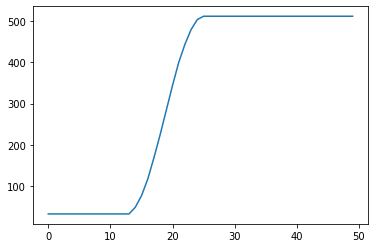

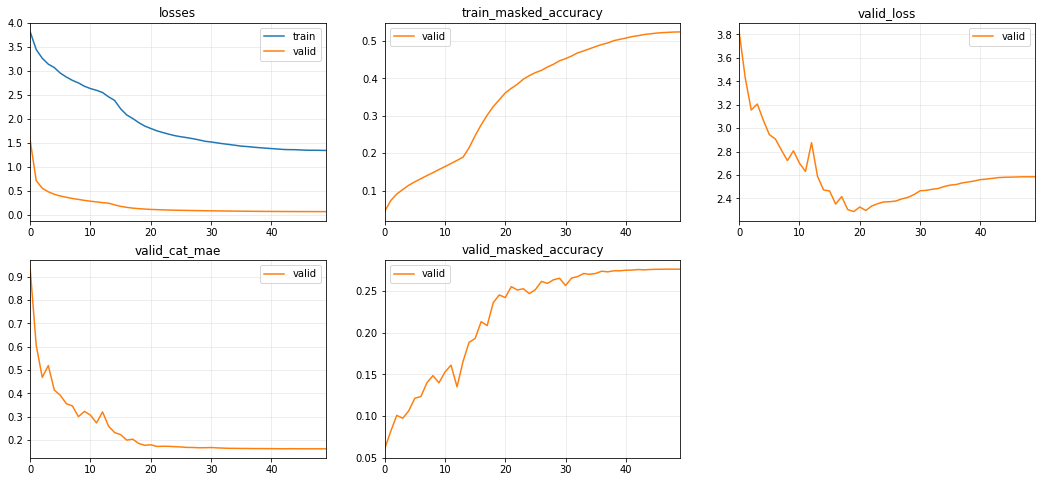

In [39]:
n_epochs = 50
sched_fn = combine_scheds([.25, .25, .5], [SchedLin(0.,0.), SchedCos(0.,1.), SchedLin(1.,1.)])
bs_range = [32, 512]
bss = []
mult = 4
for epoch in range(n_epochs):
    bs = round(sched_fn(epoch/n_epochs) * (bs_range[1] - bs_range[0]) + bs_range[0])
    bs = bs // mult * mult
    bss.append(bs)
plt.plot(bss);

try: del dls, learn, model, custom_head; gc.collect()
except: pass
# _splits = (splits[0][:100], splits[1][:100])
dls = get_ts_dls(X, y_cat_masked, splits=splits, bs=[512, 512], path=PATH)
d_model = 512
custom_head = nn.Sequential(LinLnDrop(d_model, len(i2p), p=0))
model = CustomTransformerv4(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=6, n_heads=16, kss=[1,3,5,7,9], maxpool=True,
                            n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)

cbs=[ShowGraph(), 
     BatchSizeScheduler(bss=bss),
     SaveModelCallback(fname="301021_02C", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, opt_func=ranger, loss_func=MaskedLoss(CrossEntropyLossFlat()), metrics=[cat_mae, masked_accuracy], cbs=cbs)
print(f"#parameters:{count_parameters(learn.model)}")
learn.recorder.train_metrics=True
# learn.lr_find()
# learn.fit_one_cycle(n_epochs, 3e-4, pct_start=.1)
learn.fit_flat_cos(n_epochs, 3e-4, pct_start=0)
learn.export("models/301021_02C.pkl")

In [ ]:
# epoch train_loss 	train_mae   train_ac 	valid_loss 	valid_mae 	valid_acc 	time
# 0 	4.481908 	2.600303 	0.026119 	4.429386 	1.367667 	0.035065 	02:52
# 1 	4.082306 	1.263849 	0.041392 	4.087911 	1.344328 	0.045218 	02:50
# 2 	3.930446 	1.100971 	0.050861 	4.024451 	1.112900 	0.050091 	02:50
# 3 	3.750149 	0.902524 	0.058932 	3.834291 	0.878955 	0.059130 	02:50
# 4 	3.638634 	0.778073 	0.067860 	3.554298 	0.709248 	0.073205 	02:50
# 5 	3.499788 	0.698651 	0.076538 	3.483612 	0.688405 	0.079093 	02:50
# 6 	3.371000 	0.633498 	0.083788 	3.358472 	0.604254 	0.084317 	02:50
# 7 	3.329982 	0.595381 	0.089461 	3.372949 	0.623694 	0.086783 	02:50
# 8 	3.245596 	0.562092 	0.094112 	3.278482 	0.550997 	0.094047 	02:50
# 9 	3.239040 	0.536305 	0.098177 	3.275212 	0.558439 	0.091869 	02:50
# 10 	3.146952 	0.506673 	0.102827 	3.236100 	0.601578 	0.099802 	02:50
# 11 	3.087529 	0.470390 	0.108059 	3.132899 	0.466825 	0.105113 	02:50
# 12 	3.046369 	0.439692 	0.115033 	3.064349 	0.426798 	0.109616 	02:50
# 13 	2.958417 	0.406942 	0.122177 	3.012837 	0.410123 	0.113738 	02:51
# 14 	2.875366 	0.369040 	0.131899 	2.884748 	0.358854 	0.128443 	02:51
# 15 	2.745763 	0.321367 	0.145522 	2.788444 	0.323143 	0.139142 	03:02
# 16 	2.642924 	0.287596 	0.160364 	2.744408 	0.313698 	0.146425 	03:06
# 17 	2.513176 	0.250608 	0.178413 	2.574816 	0.258007 	0.167353 	02:53
# 18 	2.425283 	0.222566 	0.196925 	2.509499 	0.244081 	0.179028 	02:39
# 19 	2.319108 	0.198993 	0.217441 	2.494434 	0.241269 	0.186408 	02:31
# 20 	2.228765 	0.181629 	0.236184 	2.453291 	0.225094 	0.192303 	02:26
# 21 	2.146244 	0.164829 	0.256179 	2.386393 	0.204452 	0.208089 	02:25
# 22 	2.078875 	0.151609 	0.276060 	2.409398 	0.205465 	0.204638 	02:23
# 23 	1.991621 	0.140337 	0.295953 	2.363736 	0.192368 	0.225277 	02:19
# 24 	1.921093 	0.130113 	0.316475 	2.323146 	0.184738 	0.233160 	02:16
# 25 	1.855857 	0.121913 	0.335457 	2.341256 	0.181595 	0.231059 	02:17
# 26 	1.791659 	0.114095 	0.353244 	2.343286 	0.177123 	0.247936 	02:15
# 27 	1.735705 	0.107456 	0.372532 	2.348964 	0.175854 	0.251413 	02:14
# 28 	1.673038 	0.100523 	0.392311 	2.360669 	0.171519 	0.254218 	02:14
# 29 	1.622344 	0.095222 	0.409697 	2.422508 	0.172611 	0.247372 	02:14
# 30 	1.569696 	0.090236 	0.426580 	2.426195 	0.169649 	0.267097 	02:12
# 31 	1.522383 	0.085520 	0.443879 	2.465645 	0.168718 	0.266164 	02:12
# 32 	1.482692 	0.081530 	0.458752 	2.483444 	0.166529 	0.271063 	02:12
# 33 	1.443568 	0.077659 	0.475418 	2.536459 	0.167496 	0.271510 	02:12
# 34 	1.404431 	0.074388 	0.489297 	2.574265 	0.166964 	0.274479 	02:11
# 35 	1.371485 	0.071218 	0.502722 	2.607430 	0.165188 	0.278974 	02:12
# 36 	1.336765 	0.068299 	0.516940 	2.634498 	0.164347 	0.280071 	02:11
# 37 	1.309770 	0.065540 	0.528670 	2.685658 	0.164636 	0.280253 	02:10
# 38 	1.282458 	0.063331 	0.540989 	2.704311 	0.165057 	0.282414 	02:08
# 39 	1.254935 	0.061119 	0.550934 	2.741260 	0.165240 	0.282575 	02:08
# 40 	1.232465 	0.059216 	0.561118 	2.767299 	0.164794 	0.284618 	02:08
# 41 	1.213171 	0.057376 	0.570854 	2.801430 	0.165117 	0.284806 	02:08
# 42 	1.197607 	0.055881 	0.578213 	2.815049 	0.165524 	0.285047 	02:08
# 43 	1.183358 	0.054699 	0.585101 	2.835237 	0.164965 	0.285076 	02:08
# 44 	1.171521 	0.053666 	0.590793 	2.845257 	0.165342 	0.286600 	02:08
# 45 	1.162580 	0.052791 	0.595363 	2.853930 	0.165232 	0.287220 	02:08
# 46 	1.155766 	0.052106 	0.598995 	2.860666 	0.165325 	0.287486 	02:08
# 47 	1.149013 	0.051633 	0.601740 	2.864211 	0.165331 	0.287770 	02:08
# 48 	1.146639 	0.051337 	0.603613 	2.865813 	0.165197 	0.287989 	02:08
# 49 	1.145244 	0.051145 	0.604538 	2.866285 	0.165202 	0.288036 	02:08

#parameters:19961632


epoch,train_loss,train_cat_mae,train_masked_accuracy,valid_loss,valid_cat_mae,valid_masked_accuracy,time
0,4.379344,2.545159,0.026699,4.465796,1.616993,0.034035,02:43
1,3.989158,1.219634,0.044490,3.907880,0.954741,0.052616,02:44
2,3.763852,0.953156,0.057243,3.772903,0.847197,0.063355,02:43
3,3.624661,0.805335,0.068582,3.575090,0.741329,0.074903,02:44
4,3.505746,0.702469,0.077291,3.458103,0.654282,0.078629,02:44
5,3.317802,0.601501,0.088340,3.363048,0.593680,0.087251,02:44
6,3.168570,0.525865,0.098337,3.153337,0.452671,0.099400,02:44
7,3.117319,0.475276,0.106260,3.112528,0.440900,0.105947,02:44
8,2.976305,0.414819,0.117482,3.024842,0.401318,0.111884,02:49
9,2.897208,0.372171,0.128178,2.932477,0.397931,0.123214,02:50


epoch:   0 - bs: 512 -->   32
Better model found at epoch 0 with valid_cat_mae value: 1.6169932849148938.


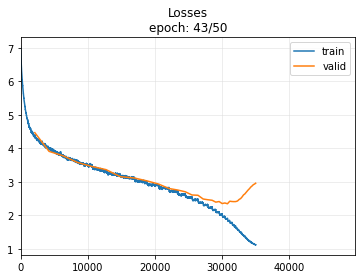

Better model found at epoch 1 with valid_cat_mae value: 0.9547410983056909.
Better model found at epoch 2 with valid_cat_mae value: 0.8471969281506517.
Better model found at epoch 3 with valid_cat_mae value: 0.741329084392503.
Better model found at epoch 4 with valid_cat_mae value: 0.6542823488070848.
Better model found at epoch 5 with valid_cat_mae value: 0.5936797975209271.
Better model found at epoch 6 with valid_cat_mae value: 0.45267069365132984.
Better model found at epoch 7 with valid_cat_mae value: 0.440900470290533.
epoch:   8 - bs:  32 -->   36
Better model found at epoch 8 with valid_cat_mae value: 0.40131769084833957.
epoch:   9 - bs:  36 -->   40
Better model found at epoch 9 with valid_cat_mae value: 0.3979307136320421.
epoch:  10 - bs:  40 -->   44
Better model found at epoch 10 with valid_cat_mae value: 0.32345446661110966.
epoch:  11 - bs:  44 -->   52
Better model found at epoch 11 with valid_cat_mae value: 0.30751650423723476.
epoch:  12 - bs:  52 -->   60
Better mod

KeyboardInterrupt: ignored

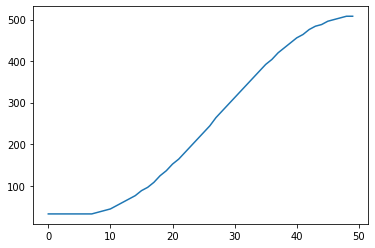

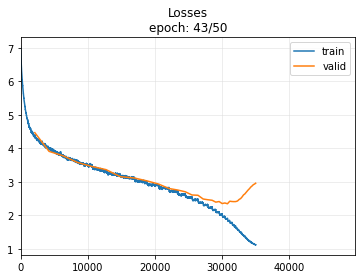

In [40]:
n_epochs = 50
sched_fn = combine_scheds([.1, .9], [SchedLin(0.,0.), SchedCos(0.,1.)])
bs_range = [32, 512]
bss = []
mult = 4
for epoch in range(n_epochs):
    bs = round(sched_fn(epoch/n_epochs) * (bs_range[1] - bs_range[0]) + bs_range[0])
    bs = bs // mult * mult
    bss.append(bs)
plt.plot(bss);

try: del dls, learn, model, custom_head; gc.collect()
except: pass
# _splits = (splits[0][:100], splits[1][:100])
dls = get_ts_dls(X, y_cat_masked, splits=splits, bs=[512, 512], path=PATH)
d_model = 512
custom_head = nn.Sequential(LinLnDrop(d_model, len(i2p), p=0))
model = CustomTransformerv4(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=6, n_heads=16, kss=[1,3,5,7,9], maxpool=True,
                            n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)

cbs=[ShowGraph(), 
     BatchSizeScheduler(bss=bss),
     SaveModelCallback(fname="301021_02CC", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, loss_func=MaskedLoss(CrossEntropyLossFlat()), metrics=[cat_mae, masked_accuracy], cbs=cbs)
print(f"#parameters:{count_parameters(learn.model)}")
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit_one_cycle(n_epochs, 3e-4, pct_start=.1)
learn.export("models/301021_02CC.pkl")

#parameters:19961632


epoch,train_loss,train_cat_mae,train_masked_accuracy,valid_loss,valid_cat_mae,valid_masked_accuracy,time
0,6.172436,7.223653,0.010180,5.930661,4.227543,0.015648,02:09
1,5.425344,2.957414,0.020513,5.135373,2.026259,0.025200,02:06
2,4.767051,1.741471,0.029859,4.570945,1.466285,0.032888,02:06
3,4.398774,1.365540,0.036725,4.340210,1.372490,0.037480,02:06
4,4.177048,1.320635,0.043178,4.106898,1.158321,0.044364,02:06
5,4.079782,1.238461,0.046815,4.012401,1.058400,0.047551,02:06
6,3.975200,1.082801,0.051580,3.885787,0.981311,0.055831,02:06
7,3.899117,0.982036,0.055857,3.836547,0.849887,0.056517,02:06
8,3.828897,0.894228,0.059842,3.729032,0.778744,0.063535,02:06
9,3.733479,0.820920,0.064751,3.657720,0.735978,0.067110,02:06


Better model found at epoch 0 with valid_cat_mae value: 4.2275425940117515.


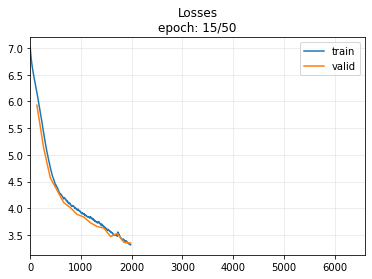

Better model found at epoch 1 with valid_cat_mae value: 2.026259056857245.
Better model found at epoch 2 with valid_cat_mae value: 1.4662845544147305.
Better model found at epoch 3 with valid_cat_mae value: 1.3724902300821522.
Better model found at epoch 4 with valid_cat_mae value: 1.15832084262335.
Better model found at epoch 5 with valid_cat_mae value: 1.0584002370902295.
Better model found at epoch 6 with valid_cat_mae value: 0.9813105028874182.
Better model found at epoch 7 with valid_cat_mae value: 0.8498871354887082.
Better model found at epoch 8 with valid_cat_mae value: 0.7787442618602106.
Better model found at epoch 9 with valid_cat_mae value: 0.7359777964255083.
Better model found at epoch 11 with valid_cat_mae value: 0.6129519667979629.
Better model found at epoch 12 with valid_cat_mae value: 0.6034326609546389.
Better model found at epoch 13 with valid_cat_mae value: 0.5636777918272998.
Better model found at epoch 14 with valid_cat_mae value: 0.5604863869276696.


KeyboardInterrupt: ignored

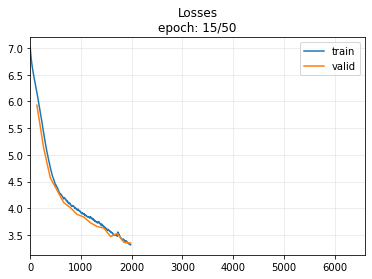

In [39]:
try: del dls, learn, model, custom_head; gc.collect()
except: pass
# _splits = (splits[0][:100], splits[1][:100])
dls = get_ts_dls(X, y_cat_masked, splits=splits, bs=[512, 512], path=PATH)
d_model = 512
custom_head = nn.Sequential(LinLnDrop(d_model, len(i2p), p=0))
model = CustomTransformerv4(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=6, n_heads=16, kss=[1,3,5,7,9], maxpool=True,
                            n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)

cbs=[ShowGraph(), 
    #  BatchSizeScheduler(bss=bss),
     SaveModelCallback(fname="301021_02BC", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, loss_func=MaskedLoss(CrossEntropyLossFlat()), metrics=[cat_mae, masked_accuracy], cbs=cbs)
print(f"#parameters:{count_parameters(learn.model)}")
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit_one_cycle(50, 3e-4)
learn.export("models/301021_02BC.pkl")

# SOTA

#parameters:19961632


epoch,train_loss,train_cat_mae,train_masked_accuracy,valid_loss,valid_cat_mae,valid_masked_accuracy,time
0,4.481908,2.600303,0.026119,4.429386,1.367667,0.035065,02:52
1,4.082306,1.263849,0.041392,4.087911,1.344328,0.045218,02:50
2,3.930446,1.100971,0.050861,4.024451,1.112900,0.050091,02:50
3,3.750149,0.902524,0.058932,3.834291,0.878955,0.059130,02:50
4,3.638634,0.778073,0.067860,3.554298,0.709248,0.073205,02:50
5,3.499788,0.698651,0.076538,3.483612,0.688405,0.079093,02:50
6,3.371000,0.633498,0.083788,3.358472,0.604254,0.084317,02:50
7,3.329982,0.595381,0.089461,3.372949,0.623694,0.086783,02:50
8,3.245596,0.562092,0.094112,3.278482,0.550997,0.094047,02:50
9,3.239040,0.536305,0.098177,3.275212,0.558439,0.091869,02:50


epoch:   0 - bs:  64 -->   32
Better model found at epoch 0 with valid_cat_mae value: 1.3676669195974704.


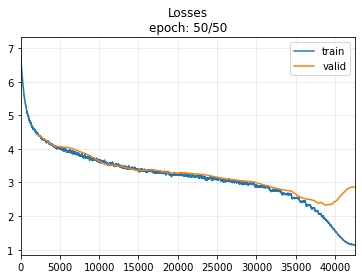

Better model found at epoch 1 with valid_cat_mae value: 1.3443283949213682.
Better model found at epoch 2 with valid_cat_mae value: 1.112900413512473.
Better model found at epoch 3 with valid_cat_mae value: 0.8789547828821841.
Better model found at epoch 4 with valid_cat_mae value: 0.709247734793486.
Better model found at epoch 5 with valid_cat_mae value: 0.6884047858042062.
Better model found at epoch 6 with valid_cat_mae value: 0.6042538549590709.
Better model found at epoch 8 with valid_cat_mae value: 0.5509974809156909.
Better model found at epoch 11 with valid_cat_mae value: 0.4668252095190608.
Better model found at epoch 12 with valid_cat_mae value: 0.42679780170117537.
Better model found at epoch 13 with valid_cat_mae value: 0.4101225973656317.
epoch:  14 - bs:  32 -->   36
Better model found at epoch 14 with valid_cat_mae value: 0.35885386214228854.
epoch:  15 - bs:  36 -->   44
Better model found at epoch 15 with valid_cat_mae value: 0.32314349107819207.
epoch:  16 - bs:  44 -

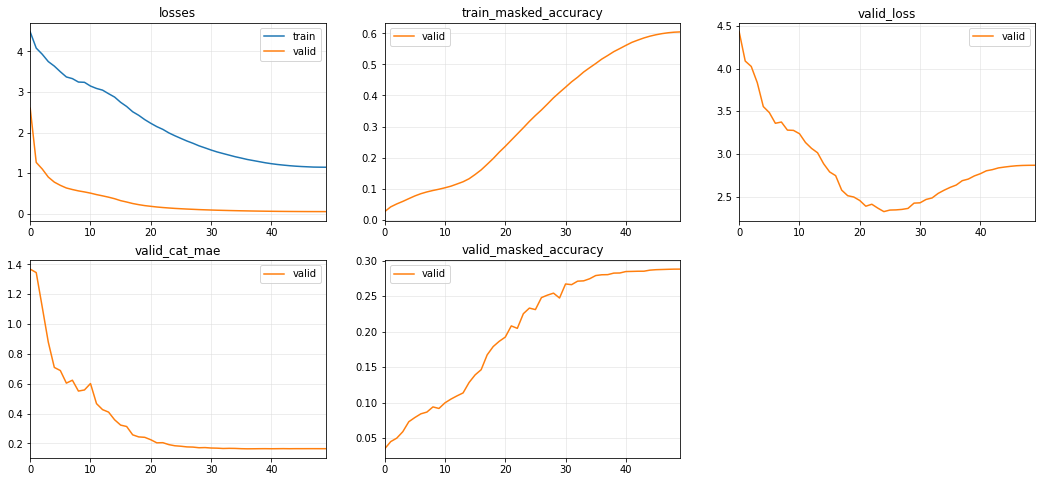

In [53]:
# NEW SOTA: 0.1643

n_epochs = 50
# sched_fn = combine_scheds([.1, .4, .5], [SchedLin(0.,0.), SchedCos(0.,1.), SchedLin(1.,1.)])
sched_fn = combine_scheds([.25, .5, .25], [SchedLin(0.,0.), SchedCos(0.,1.), SchedLin(1.,1.)])
bs_range = [32, 512]
bss = []

mult = 4
for epoch in range(n_epochs):
    bs = round(sched_fn(epoch/n_epochs) * (bs_range[1] - bs_range[0]) + bs_range[0])
    bs = bs // mult * mult
    bss.append(bs)
plt.plot(bss);

try: del dls, learn, model, custom_head; gc.collect()
except: pass
# _splits = (splits[0][:100], splits[1][:100])
dls = get_ts_dls(X, y_cat_masked, splits=splits, bs=[64, 512], path=PATH)
d_model = 512
custom_head = nn.Sequential(LinLnDrop(d_model, len(i2p), p=0))
model = CustomTransformerv4(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=6, n_heads=16, kss=[1,3,5,7,9], maxpool=True,
                            n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)

cbs=[ShowGraph(), 
     BatchSizeScheduler(bss=bss),

     SaveModelCallback(fname="301021_02BC", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, loss_func=MaskedLoss(CrossEntropyLossFlat()), metrics=[cat_mae, masked_accuracy], cbs=cbs)
print(f"#parameters:{count_parameters(learn.model)}")
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit_one_cycle(n_epochs, 3e-4)
learn.export("models/301021_02BC.pkl")

In [ ]:
# 1 	3.965824 	1.201168 	0.046727 	4.026323 	1.086517 	0.049749 	02:44
# 2 	3.778182 	0.936822 	0.059623 	3.789783 	0.908096 	0.065290 	02:44
# 3 	3.542310 	0.789801 	0.070100 	3.528497 	0.733808 	0.076757 	02:44
# 4 	3.388939 	0.646173 	0.082755 	3.395183 	0.586929 	0.083820 	02:44
# 5 	3.230413 	0.533197 	0.095913 	3.233033 	0.519991 	0.095201 	02:47
# 6 	3.020178 	0.438604 	0.111920 	3.066100 	0.477027 	0.110712 	02:59
# 7 	2.851260 	0.351428 	0.131972 	2.963189 	0.388532 	0.122145 	02:38
# 8 	2.707180 	0.299217 	0.150340 	2.740959 	0.295151 	0.139460 	02:29
# 9 	2.583724 	0.255826 	0.170526 	2.638060 	0.274541 	0.156247 	02:25
# 10 	2.455490 	0.228187 	0.189190 	2.558895 	0.248109 	0.170186 	02:20
# 11 	2.363619 	0.202712 	0.207197 	2.504811 	0.236361 	0.176686 	02:13
# 12 	2.272467 	0.184885 	0.226188 	2.447876 	0.217785 	0.184641 	02:14
# 13 	2.214932 	0.172284 	0.241248 	2.426804 	0.214548 	0.191549 	02:13
# 14 	2.142677 	0.159686 	0.256527 	2.398669 	0.206046 	0.204985 	02:12
# 15 	2.080005 	0.149612 	0.273345 	2.396059 	0.202630 	0.209936 	02:12
# 16 	2.022042 	0.141629 	0.286122 	2.378300 	0.195359 	0.217083 	02:10
# 17 	1.966429 	0.133961 	0.301201 	2.354227 	0.188976 	0.224134 	02:11
# 18 	1.926153 	0.128074 	0.312252 	2.382670 	0.190321 	0.222559 	02:10
# 19 	1.885476 	0.121758 	0.327011 	2.372868 	0.183292 	0.232376 	02:10
# 20 	1.837586 	0.116670 	0.339904 	2.364459 	0.182862 	0.234205 	02:09
# 21 	1.795851 	0.112644 	0.350203 	2.398539 	0.181432 	0.235225 	02:06
# 22 	1.770556 	0.108833 	0.359791 	2.395560 	0.178045 	0.241719 	02:06
# 23 	1.723323 	0.104037 	0.373580 	2.411291 	0.176118 	0.243026 	02:06
# 24 	1.686019 	0.099744 	0.387131 	2.436671 	0.176041 	0.246833 	02:06
# 25 	1.656825 	0.096268 	0.397673 	2.462177 	0.175893 	0.245801 	02:06
# 26 	1.618825 	0.092512 	0.410590 	2.465394 	0.173157 	0.251274 	02:07
# 27 	1.591528 	0.089505 	0.421373 	2.493532 	0.172142 	0.251641 	02:06
# 28 	1.555013 	0.086272 	0.433779 	2.500030 	0.171316 	0.258005 	02:07
# 29 	1.529274 	0.083716 	0.442939 	2.519596 	0.169961 	0.259658 	02:06
# 30 	1.506502 	0.080920 	0.454056 	2.539109 	0.169640 	0.260224 	02:06
# 31 	1.483112 	0.078721 	0.463051 	2.563236 	0.169246 	0.260861 	02:06
# 32 	1.462686 	0.076421 	0.472459 	2.576690 	0.168375 	0.261734 	02:06
# 33 	1.444905 	0.074993 	0.479436 	2.589312 	0.168437 	0.263091 	02:06
# 34 	1.431535 	0.073480 	0.485635 	2.598803 	0.168071 	0.263541 	02:06
# 35 	1.417388 	0.072265 	0.490919 	2.605434 	0.167713 	0.264707 	02:06
# 36 	1.411136 	0.071424 	0.495253 	2.612082 	0.167604 	0.265418 	02:06
# 37 	1.402381 	0.070587 	0.498577 	2.615824 	0.167508 	0.265484 	02:07
# 38 	1.396758 	0.070279 	0.500288 	2.617201 	0.167715 	0.265576 	02:07
# 39 	1.399275 	0.070053 	0.501476 	2.617812 	0.167606 	0.265873 	02:06

#parameters:19961632


epoch,train_loss,train_cat_mae,train_masked_accuracy,valid_loss,valid_cat_mae,valid_masked_accuracy,time
0,4.329933,2.465933,0.027197,4.312337,1.251901,0.038243,02:46
1,3.965824,1.201168,0.046727,4.026323,1.086517,0.049749,02:44
2,3.778182,0.936822,0.059623,3.789783,0.908096,0.065290,02:44
3,3.542310,0.789801,0.070100,3.528497,0.733808,0.076757,02:44
4,3.388939,0.646173,0.082755,3.395183,0.586929,0.083820,02:44
5,3.230413,0.533197,0.095913,3.233033,0.519991,0.095201,02:47
6,3.020178,0.438604,0.111920,3.066100,0.477027,0.110712,02:59
7,2.851260,0.351428,0.131972,2.963189,0.388532,0.122145,02:38
8,2.707180,0.299217,0.150340,2.740959,0.295151,0.139460,02:29
9,2.583724,0.255826,0.170526,2.638060,0.274541,0.156247,02:25


epoch:   0 - bs:  64 -->   32
Better model found at epoch 0 with valid_cat_mae value: 1.2519014659764212.


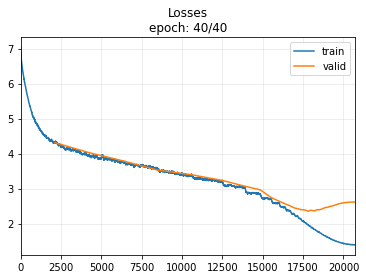

Better model found at epoch 1 with valid_cat_mae value: 1.086517452546732.
Better model found at epoch 2 with valid_cat_mae value: 0.9080958039392151.
Better model found at epoch 3 with valid_cat_mae value: 0.733808324924278.
Better model found at epoch 4 with valid_cat_mae value: 0.5869294416026898.
epoch:   5 - bs:  32 -->   36
Better model found at epoch 5 with valid_cat_mae value: 0.5199907959622165.
epoch:   6 - bs:  36 -->   48
Better model found at epoch 6 with valid_cat_mae value: 0.47702699593504033.
epoch:   7 - bs:  48 -->   72
Better model found at epoch 7 with valid_cat_mae value: 0.3885316951572332.
epoch:   8 - bs:  72 -->  100
Better model found at epoch 8 with valid_cat_mae value: 0.2951505248391418.
epoch:   9 - bs: 100 -->  136
Better model found at epoch 9 with valid_cat_mae value: 0.2745414853863166.
epoch:  10 - bs: 136 -->  180
Better model found at epoch 10 with valid_cat_mae value: 0.24810928458046355.
epoch:  11 - bs: 180 -->  224
Better model found at epoch 1

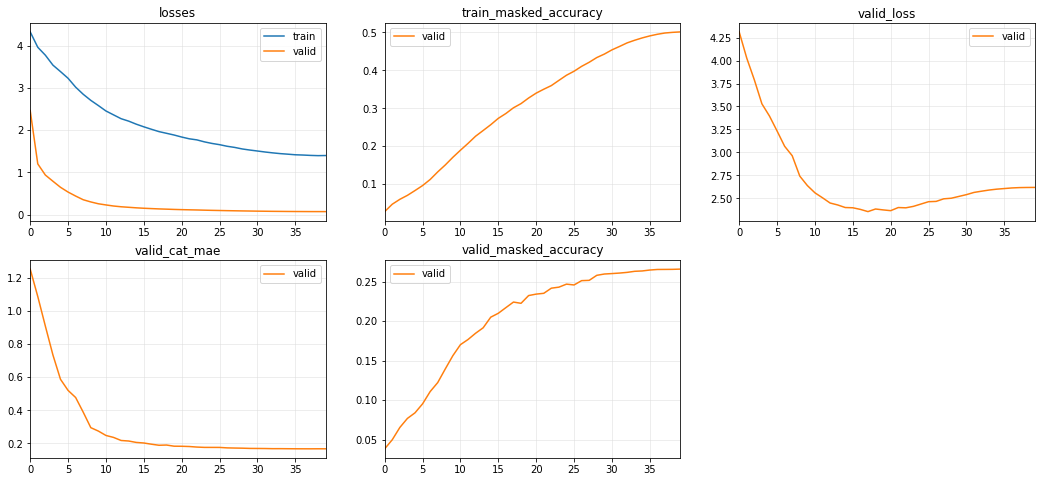

In [38]:
n_epochs = 40
sched_fn = combine_scheds([.1, .4, .5], [SchedLin(0.,0.), SchedCos(0.,1.), SchedLin(1.,1.)])
bs_range = [32, 512]
bss = []

mult = 4
for epoch in range(n_epochs):
    bs = round(sched_fn(epoch/n_epochs) * (bs_range[1] - bs_range[0]) + bs_range[0])
    bs = bs // mult * mult
    bss.append(bs)
plt.plot(bss);

try: del dls, learn, model, custom_head; gc.collect()
except: pass
# _splits = (splits[0][:100], splits[1][:100])
dls = get_ts_dls(X, y_cat_masked, splits=splits, bs=[64, 512], path=PATH)
d_model = 512
custom_head = nn.Sequential(LinLnDrop(d_model, len(i2p), p=0))
model = CustomTransformerv4(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=6, n_heads=16, kss=[1,3,5,7,9], maxpool=True,
                            n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)

cbs=[ShowGraph(), 
     BatchSizeScheduler(bss=bss),
    #  ReduceLROnPlateau(monitor='valid_loss', patience=1),
     #  GradientClip(), # makes training very slow!!
     # EarlyStoppingCallback(monitor="valid_cat_mae", comp=np.less, patience=3),
     SaveModelCallback(fname="301021_02C", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, loss_func=MaskedLoss(CrossEntropyLossFlat()), metrics=[cat_mae, masked_accuracy], cbs=cbs)
print(f"#parameters:{count_parameters(learn.model)}")
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit_one_cycle(n_epochs, 3e-4, pct_start=.1)
learn.export("models/301021_02C.pkl")

In [ ]:
# epoch train_loss 	train_mae   train_ac 	valid_loss 	valid_mae 	valid_acc 	time
# 0 	4.344467 	2.608420 	0.026241 	4.281216 	1.382984 	0.037864 	02:49
# 1 	4.003026 	1.263403 	0.044309 	3.939538 	0.984271 	0.053298 	02:49
# 2 	3.719296 	0.972254 	0.058982 	3.754219 	0.900616 	0.065914 	02:49
# 3 	3.501369 	0.761770 	0.072867 	3.443472 	0.627598 	0.082204 	02:49
# 4 	3.324708 	0.628113 	0.084840 	3.360324 	0.598745 	0.086731 	02:49
# 5 	3.260867 	0.545560 	0.093783 	3.185797 	0.483596 	0.097037 	02:49
# 6 	3.088211 	0.456445 	0.107042 	3.158556 	0.486361 	0.103398 	03:11
# 7 	3.019465 	0.407380 	0.116248 	3.117893 	0.433554 	0.107863 	03:00
# 8 	2.885124 	0.360276 	0.128054 	2.890175 	0.345344 	0.125511 	03:06
# 9 	2.785695 	0.322456 	0.138848 	2.855351 	0.329897 	0.130741 	02:53
# 10 	2.684131 	0.288635 	0.152080 	2.744560 	0.312528 	0.144230 	02:48
# 11 	2.615916 	0.259953 	0.165708 	2.693941 	0.282555 	0.148809 	02:38
# 12 	2.531577 	0.236555 	0.176900 	2.638390 	0.270115 	0.156808 	02:38
# 13 	2.441788 	0.216377 	0.191595 	2.556758 	0.248153 	0.169728 	02:32
# 14 	2.360801 	0.198615 	0.206363 	2.542535 	0.248161 	0.175049 	02:26
# 15 	2.285955 	0.184612 	0.221662 	2.462980 	0.221567 	0.185481 	02:25
# 16 	2.210352 	0.168844 	0.237513 	2.456681 	0.217331 	0.187792 	02:23
# 17 	2.151229 	0.158398 	0.251698 	2.476849 	0.215319 	0.189619 	02:23
# 18 	2.085770 	0.148581 	0.266645 	2.430634 	0.206331 	0.201030 	02:19
# 19 	2.020141 	0.139405 	0.281998 	2.413068 	0.198221 	0.209321 	02:16
# 20 	1.963755 	0.130621 	0.298988 	2.415575 	0.195723 	0.213733 	02:15
# 21 	1.900144 	0.123096 	0.315097 	2.400228 	0.188706 	0.219502 	02:16
# 22 	1.847360 	0.116073 	0.330432 	2.434088 	0.187023 	0.220030 	02:15
# 23 	1.797178 	0.110127 	0.346174 	2.426463 	0.182212 	0.226385 	02:13
# 24 	1.746619 	0.104224 	0.360814 	2.435876 	0.179204 	0.231443 	02:15
# 25 	1.708158 	0.098723 	0.376454 	2.458131 	0.179486 	0.234815 	02:14
# 26 	1.667477 	0.095007 	0.388416 	2.484668 	0.177547 	0.235903 	02:14
# 27 	1.631719 	0.090876 	0.401700 	2.501895 	0.174874 	0.239674 	02:13
# 28 	1.598276 	0.087425 	0.413948 	2.528867 	0.174160 	0.241280 	02:12
# 29 	1.563757 	0.084026 	0.425292 	2.545595 	0.173505 	0.243350 	02:12
# 30 	1.536972 	0.081377 	0.436047 	2.558975 	0.172386 	0.244355 	02:12
# 31 	1.516528 	0.079296 	0.443815 	2.583452 	0.172035 	0.247634 	02:11
# 32 	1.496417 	0.077121 	0.452193 	2.597121 	0.171213 	0.246619 	02:12
# 33 	1.479645 	0.075547 	0.458291 	2.605030 	0.170862 	0.247693 	02:12
# 34 	1.464739 	0.074218 	0.464234 	2.617437 	0.170916 	0.248409 	02:09
# 35 	1.452648 	0.073137 	0.468986 	2.626413 	0.170650 	0.249068 	02:11
# 36 	1.448922 	0.072353 	0.472102 	2.628833 	0.170763 	0.248893 	02:11
# 37 	1.441296 	0.071796 	0.474424 	2.631719 	0.170616 	0.249317 	02:08
# 38 	1.438561 	0.071400 	0.476164 	2.632394 	0.170549 	0.248964 	02:08
# 39 	1.438651 	0.071196 	0.476830 	2.632704 	0.170552 	0.249204 	02:08

# Experiments 29/10/21

In [ ]:
try: del dls, learn, model, custom_head; gc.collect()
except: pass
_splits = (splits[0][:512], splits[1][:512])
# dls = get_ts_dls(np.random.rand(*X.shape), y_cat, splits=_splits, bs=[64, 512], path=PATH)
dls = get_ts_dls(X, y_cat_masked, splits=splits, bs=[64, 512], path=PATH)
d_model = 512
custom_head = nn.Sequential(LinLnDrop(d_model, len(i2p), p=0))
model = SpaceTimeFormer(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=6, n_heads=16, kss=[1,3,5,7,9], maxpool=True,
                        n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)
cbs=[ShowGraph(), 
     SaveModelCallback(fname="291021_01C", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, loss_func=MaskedLoss(CrossEntropyLossFlat()), metrics=[cat_mae, masked_accuracy], cbs=cbs)
print(f"#parameters:{count_parameters(learn.model)}")
learn.recorder.train_metrics=True
# learn.lr_find()
# learn.fit(n_epochs, 3e-4)
learn.fit_one_cycle(40, 1e-4, pct_start=3/40)
learn.export("models/291021_01C.pkl")

#parameters:19425332


epoch,train_loss,train_cat_mae,train_masked_accuracy,valid_loss,valid_cat_mae,valid_masked_accuracy,time


KeyboardInterrupt: ignored

#parameters:19930692


epoch,train_loss,train_cat_mae,train_masked_accuracy,valid_loss,valid_cat_mae,valid_masked_accuracy,time
0,4.199156,1.902759,0.031419,4.116492,1.293074,0.042792,02:49
1,3.902588,1.078249,0.049153,3.836428,0.924925,0.055381,02:49
2,3.812777,0.904785,0.059728,3.800471,0.865467,0.063569,02:49
3,4.463323,1.045218,0.057036,4.442166,1.642898,0.037314,02:49
4,4.418528,1.649230,0.034923,4.348547,1.517336,0.037052,02:49
5,3.583887,0.821327,0.062341,3.578136,0.654436,0.071479,02:49
6,3.431986,0.609112,0.077311,3.415182,0.555121,0.081213,03:13


epoch:   0 - bs:  64 -->   32
Better model found at epoch 0 with valid_cat_mae value: 1.293074171822473.


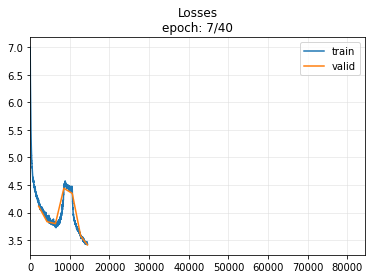

Better model found at epoch 1 with valid_cat_mae value: 0.9249246575889544.
Better model found at epoch 2 with valid_cat_mae value: 0.8654669730579873.
Epoch 3: lr 0.0009971804511273669 --> 9.971804511273669e-05
Epoch 4: lr 0.001 --> 0.0001
Better model found at epoch 5 with valid_cat_mae value: 0.6544359522758849.
epoch:   6 - bs:  32 -->   40
Better model found at epoch 6 with valid_cat_mae value: 0.5551205212950303.
epoch:   7 - bs:  40 -->   44


KeyboardInterrupt: ignored

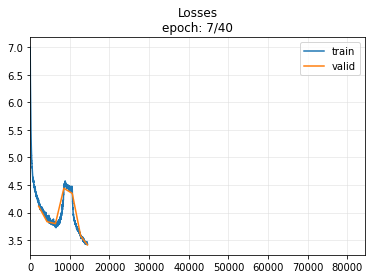

In [ ]:
try: del dls, learn, model, custom_head; gc.collect()
except: pass
_splits = (splits[0][:512], splits[1][:512])
# dls = get_ts_dls(np.random.rand(*X.shape), y_cat, splits=_splits, bs=[64, 512], path=PATH)
dls = get_ts_dls(X, y_cat_masked, splits=splits, bs=[64, 512], path=PATH)
d_model = 512
custom_head = nn.Sequential(LinLnDrop(d_model, len(i2p), p=0))
model = CustomTransformerv4(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=6, n_heads=16, kss=[1,3,5,7,9], maxpool=True,
                            n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)

cbs=[ShowGraph(), 
     BatchSizeScheduler(bss=bss),
     ReduceLROnPlateauWithWarmup(warmup=.1),
    #  GradientClip(), # makes training very slow!!
     # EarlyStoppingCallback(monitor="valid_cat_mae", comp=np.less, patience=3),
     SaveModelCallback(fname="291021_01C", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, loss_func=MaskedLoss(CrossEntropyLossFlat()), metrics=[cat_mae, masked_accuracy], cbs=cbs)
print(f"#parameters:{count_parameters(learn.model)}")
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit(n_epochs, 3e-4)
# learn.fit_one_cycle(n_epochs, 3e-4, pct_start=3/40)
learn.export("models/291021_01C.pkl")

#parameters:19930692


epoch,train_loss,train_cat_mae,train_accuracy,valid_loss,valid_cat_mae,valid_accuracy,time
0,3.241543,0.868899,0.078408,3.232673,0.588043,0.093608,02:48
1,3.016061,0.511821,0.104169,3.057464,0.483344,0.108562,02:48
2,2.926391,0.421191,0.117511,2.887356,0.382732,0.121339,02:48
3,2.816712,0.371985,0.127124,2.827365,0.363228,0.128386,02:48
4,2.752943,0.341573,0.134869,2.804728,0.355481,0.131476,02:48
5,2.692016,0.313029,0.142415,2.746629,0.322053,0.137745,02:48
6,2.625707,0.277257,0.152452,2.641188,0.277207,0.146761,03:14
7,2.515442,0.245927,0.164376,2.568678,0.254151,0.156364,02:48
8,2.460653,0.223335,0.175764,2.515571,0.239870,0.164587,02:36
9,2.395500,0.206499,0.186437,2.481163,0.231019,0.168976,02:29


epoch:   0 - bs:  64 -->   32
Better model found at epoch 0 with valid_cat_mae value: 0.5880428546894848.


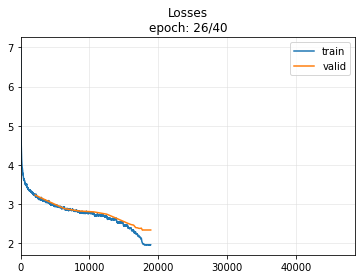

Better model found at epoch 1 with valid_cat_mae value: 0.48334367244647614.
Better model found at epoch 2 with valid_cat_mae value: 0.3827322874183472.
Better model found at epoch 3 with valid_cat_mae value: 0.36322763502653627.
Better model found at epoch 4 with valid_cat_mae value: 0.3554807718714722.
epoch:   5 - bs:  32 -->   36
Better model found at epoch 5 with valid_cat_mae value: 0.3220534760721033.
epoch:   6 - bs:  36 -->   48
Better model found at epoch 6 with valid_cat_mae value: 0.2772068569648832.
epoch:   7 - bs:  48 -->   72
Better model found at epoch 7 with valid_cat_mae value: 0.25415099116219164.
epoch:   8 - bs:  72 -->  100
Better model found at epoch 8 with valid_cat_mae value: 0.23987043109961112.
epoch:   9 - bs: 100 -->  136
Better model found at epoch 9 with valid_cat_mae value: 0.23101883658337266.
epoch:  10 - bs: 136 -->  180
Better model found at epoch 10 with valid_cat_mae value: 0.22099682082850053.
epoch:  11 - bs: 180 -->  224
Better model found at e

KeyboardInterrupt: ignored

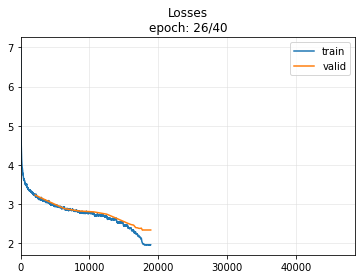

In [ ]:
try: del dls, learn, model, custom_head; gc.collect()
except: pass
_splits = (splits[0][:512], splits[1][:512])
# dls = get_ts_dls(np.random.rand(*X.shape), y_cat, splits=_splits, bs=[64, 512], path=PATH)
dls = get_ts_dls(X, y_cat, splits=splits, bs=[64, 512], path=PATH)
d_model = 512
custom_head = nn.Sequential(LinLnDrop(d_model, len(i2p), p=0))
model = CustomTransformerv4(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=6, n_heads=16, kss=[1,3,5,7,9], maxpool=True,
                            n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)

cbs=[ShowGraph(), 
     BatchSizeScheduler(bss=bss),
     ReduceLROnPlateauWithWarmup(warmup=.1),
    #  GradientClip(), # makes training very slow!!
     # EarlyStoppingCallback(monitor="valid_cat_mae", comp=np.less, patience=3),
     SaveModelCallback(fname="291021_01C", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, loss_func=CrossEntropyLossFlat(), metrics=[cat_mae, accuracy], cbs=cbs)
print(f"#parameters:{count_parameters(learn.model)}")
learn.recorder.train_metrics=True
learn.fit(40, 3e-4)
# learn.lr_find()
# learn.fit_one_cycle(10, 3e-4, pct_start=3/40)
learn.export("models/291021_01C.pkl")

In [ ]:
# epoch train_loss 	train_mae   train_ac 	valid_loss 	valid_mae 	valid_acc 	time
# 0 	4.361036 	2.775564 	0.025980 	4.288733 	1.341819 	0.037541 	02:50
# 1 	4.025403 	1.226461 	0.044179 	3.919791 	0.961204 	0.054989 	02:49
# 2 	3.761347 	0.961392 	0.059238 	3.789016 	0.861735 	0.058384 	02:49
# 3 	3.486250 	0.754643 	0.073326 	3.499189 	0.647927 	0.077378 	02:49
# 4 	3.338680 	0.628776 	0.084728 	3.383444 	0.567936 	0.086457 	02:49
# 5 	3.238310 	0.546757 	0.093810 	3.266580 	0.515825 	0.095436 	02:49
# 6 	3.082569 	0.462553 	0.105682 	3.071764 	0.416528 	0.107471 	03:12
# 7 	2.986220 	0.400885 	0.117988 	3.064853 	0.418088 	0.107174 	03:14
# 8 	2.824320 	0.339225 	0.132847 	2.902205 	0.352342 	0.122708 	02:48
# 9 	2.728107 	0.301108 	0.146760 	2.790734 	0.314512 	0.137694 	02:40
# 10 	2.614444 	0.263436 	0.161497 	2.730574 	0.304836 	0.148421 	02:35
# 11 	2.521015 	0.236722 	0.178005 	2.663227 	0.273963 	0.151862 	02:28
# 12 	2.434259 	0.214540 	0.192062 	2.555295 	0.244225 	0.171021 	02:23
# 13 	2.353673 	0.194451 	0.208987 	2.503498 	0.229864 	0.180998 	02:24
# 14 	2.285930 	0.180828 	0.222769 	2.465761 	0.222626 	0.185703 	02:19
# 15 	2.204458 	0.166606 	0.238727 	2.455380 	0.214723 	0.188474 	02:16
# 16 	2.134715 	0.155795 	0.253676 	2.439266 	0.206727 	0.196031 	02:16
# 17 	2.084255 	0.147140 	0.266033 	2.419710 	0.201590 	0.203487 	02:14
# 18 	2.025476 	0.137194 	0.282806 	2.396042 	0.196011 	0.208023 	02:13
# 19 	1.964155 	0.130054 	0.296584 	2.412640 	0.191710 	0.211148 	02:13
# 20 	1.911466 	0.122892 	0.309883 	2.396802 	0.190046 	0.218241 	02:12
# 21 	1.868078 	0.117465 	0.322154 	2.421682 	0.185443 	0.220237 	02:12
# 22 	1.839904 	0.111796 	0.336523 	2.420815 	0.184239 	0.223950 	02:12
# 23 	1.789384 	0.107133 	0.348218 	2.448867 	0.181453 	0.226997 	02:11
# 24 	1.747367 	0.102754 	0.359683 	2.453830 	0.180563 	0.229269 	02:11
# 25 	1.717181 	0.098670 	0.371808 	2.474498 	0.178481 	0.232895 	02:11
# 26 	1.683649 	0.095675 	0.381400 	2.484410 	0.176457 	0.233795 	02:11
# 27 	1.654719 	0.092033 	0.392080 	2.505431 	0.176273 	0.235153 	02:11
# 28 	1.624144 	0.089252 	0.401800 	2.526016 	0.176413 	0.237379 	02:10
# 29 	1.602517 	0.086764 	0.411136 	2.543175 	0.174698 	0.237714 	02:08
# 30 	1.582831 	0.084527 	0.418603 	2.560553 	0.173361 	0.239309 	02:08
# 31 	1.559705 	0.082453 	0.425735 	2.568506 	0.172954 	0.241766 	02:08
# 32 	1.544550 	0.080594 	0.433670 	2.579909 	0.173261 	0.241555 	02:08
# 33 	1.526133 	0.078946 	0.439699 	2.590924 	0.172601 	0.243774 	02:08
# 34 	1.515443 	0.077800 	0.444604 	2.599440 	0.172822 	0.243377 	02:08
# 35 	1.506232 	0.076831 	0.448557 	2.604970 	0.172132 	0.244292 	02:08
# 36 	1.497507 	0.075953 	0.452199 	2.608706 	0.172026 	0.244630 	02:08
# 37 	1.492408 	0.075377 	0.454685 	2.612478 	0.172303 	0.244542 	02:08
# 38 	1.488867 	0.074924 	0.456319 	2.613427 	0.172210 	0.244568 	02:08
# 39 	1.485942 	0.074810 	0.456849 	2.614207 	0.172284 	0.244673 	02:08

In [ ]:
try: del dls, learn, model, custom_head; gc.collect()
except: pass
# _splits = (splits[0][:64], splits[0][:64])
dls = get_ts_dls(X, y_cat, splits=splits, bs=[64, 512], path=PATH)
hidden_size = [512] * 3
custom_head = nn.Sequential(Transpose(1,2), LinLnDrop(hidden_size[0]*2, hidden_size[0], p=0., act=Mish()), LinLnDrop(hidden_size[0], len(i2p), p=0))
model = CustomLSTMv4(dls.vars, len(i2p), dls.len, hidden_size=hidden_size, kss=[1, 3, 5, 7, 9], maxpool=True,
                            n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)
cbs=[ShowGraph(), 
     ReduceLROnPlateau(monitor='valid_loss', patience=1),
     # EarlyStoppingCallback(monitor="valid_cat_mae", comp=np.less, patience=3),
     SaveModelCallback(fname="281021_01C_C", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, loss_func=CrossEntropyLossFlat(), metrics=[cat_mae, accuracy], cbs=cbs)
print(f"#parameters:{count_parameters(learn.model)}")
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit_one_cycle(40, 1e-3, pct_start=3/40)
learn.export("models/281021_01C_C.pkl")

# Experiments 28/10/21

#parameters:19930692


epoch,train_loss,train_cat_mae,train_accuracy,valid_loss,valid_cat_mae,valid_accuracy,time
0,3.279104,1.318604,0.072036,3.269840,0.624387,0.089420,02:38
1,3.093220,0.522676,0.099166,3.151551,0.528735,0.100432,02:38
2,2.960500,0.435717,0.112401,2.954708,0.394452,0.115886,02:38
3,2.888610,0.381553,0.122287,2.868994,0.372821,0.123943,02:38
4,2.777761,0.342532,0.130910,2.821335,0.348797,0.130199,02:38
5,2.726413,0.318522,0.138015,2.717076,0.297575,0.139206,02:39
6,2.693242,0.297109,0.144535,2.734374,0.313367,0.136827,02:38
7,2.494469,0.228322,0.172816,2.546626,0.235015,0.160676,02:39
8,2.460467,0.218497,0.178756,2.526033,0.231185,0.163859,02:39
9,2.452301,0.213477,0.181922,2.510738,0.227655,0.165987,02:38


Better model found at epoch 0 with valid_cat_mae value: 0.6243865946937879.


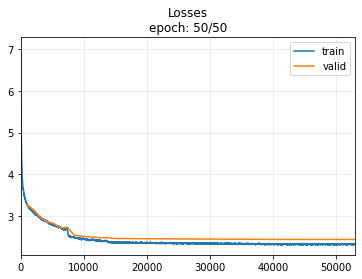

Better model found at epoch 1 with valid_cat_mae value: 0.5287346789424288.
Better model found at epoch 2 with valid_cat_mae value: 0.39445152461708116.
Better model found at epoch 3 with valid_cat_mae value: 0.3728212689209553.
Better model found at epoch 4 with valid_cat_mae value: 0.3487971762542214.
Better model found at epoch 5 with valid_cat_mae value: 0.29757502841960853.
Epoch 6: reducing lr to 2.9999999999999997e-05
Better model found at epoch 7 with valid_cat_mae value: 0.23501508726689932.
Better model found at epoch 8 with valid_cat_mae value: 0.23118492481964406.
Better model found at epoch 9 with valid_cat_mae value: 0.22765479273468567.
Better model found at epoch 10 with valid_cat_mae value: 0.22384699279890596.
Better model found at epoch 11 with valid_cat_mae value: 0.22123686841262077.
Epoch 12: reducing lr to 2.9999999999999997e-06
Better model found at epoch 13 with valid_cat_mae value: 0.21578623918328682.
Better model found at epoch 14 with valid_cat_mae value: 0

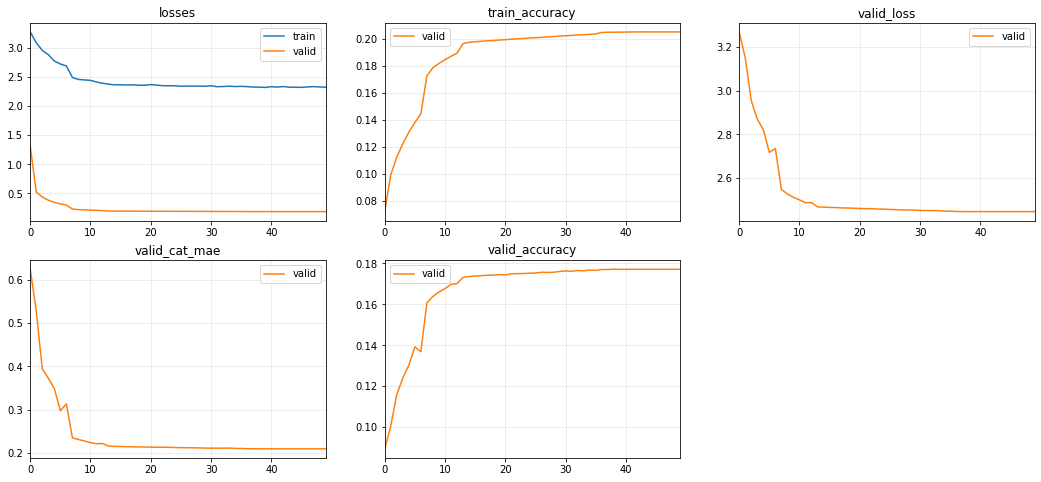

In [ ]:
# ReduceLROnPlateau(monitor='valid_loss', patience=1), CustomTransformerv4
try: del dls, learn, model, custom_head; gc.collect()
except: pass
# _splits = (splits[0][:100], splits[1][:100])
dls = get_ts_dls(X, y_cat, splits=splits, bs=[64, 512], path=PATH)
model = CustomTransformerv4(dls.vars, len(i2p), dls.len, d_model=512, n_layers=6, n_heads=16, kss=[1, 3, 5, 7, 9], maxpool=True,
                            n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos)
cbs=[ShowGraph(), 
     ReduceLROnPlateau(monitor='valid_loss', patience=1),
     EarlyStoppingCallback(monitor="valid_cat_mae", comp=np.less, patience=5), # 10% of epochs
     SaveModelCallback(fname="281021_01C_C", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, opt_func=ranger, loss_func=CrossEntropyLossFlat(), metrics=[cat_mae, accuracy], cbs=cbs)
print(f"#parameters:{count_parameters(learn.model)}")
learn.recorder.train_metrics=True
# learn.lr_find()
# learn.fit_one_cycle(50, 3e-4, pct_start=3/50)
learn.fit(50, 3e-4, wd=1e-2)
learn.export("models/281021_01C_C.pkl")

epoch,train_loss,train_cat_mae,train_accuracy,valid_loss,valid_cat_mae,valid_accuracy,time
0,3.585991,1.966828,0.057375,3.544491,0.783471,0.076604,02:40
1,3.342628,0.742982,0.082641,3.317189,0.646165,0.088597,02:41
2,3.091244,0.565712,0.097766,3.080154,0.464866,0.102971,02:41
3,2.944627,0.457553,0.112066,2.912442,0.397257,0.119826,02:41
4,2.848496,0.389185,0.123894,2.851020,0.363320,0.124904,02:41
5,2.783560,0.347482,0.133024,2.770077,0.329527,0.134163,02:41
6,2.715715,0.322354,0.140380,2.749387,0.323713,0.136412,02:41
7,2.656749,0.297950,0.146332,2.711429,0.304042,0.141905,02:41
8,2.619706,0.282182,0.152685,2.638403,0.282755,0.148010,02:42
9,2.598048,0.269647,0.157876,2.613862,0.271477,0.151256,02:41


Better model found at epoch 0 with valid_cat_mae value: 0.783470938959644.


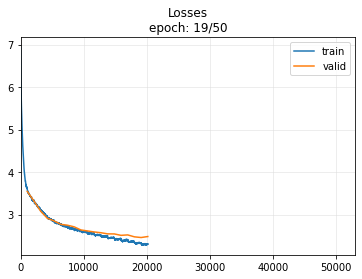

Better model found at epoch 1 with valid_cat_mae value: 0.6461652349712674.
Better model found at epoch 2 with valid_cat_mae value: 0.46486559909708924.
Better model found at epoch 3 with valid_cat_mae value: 0.39725662215029384.
Better model found at epoch 4 with valid_cat_mae value: 0.36331976391495896.
Better model found at epoch 5 with valid_cat_mae value: 0.32952733023290376.
Better model found at epoch 6 with valid_cat_mae value: 0.3237128443064364.
Better model found at epoch 7 with valid_cat_mae value: 0.3040418707355263.
Better model found at epoch 8 with valid_cat_mae value: 0.2827547398248529.
Better model found at epoch 9 with valid_cat_mae value: 0.27147704575634674.
Better model found at epoch 10 with valid_cat_mae value: 0.25859961681744215.
Better model found at epoch 12 with valid_cat_mae value: 0.24489046551162716.
Better model found at epoch 14 with valid_cat_mae value: 0.23523498529640877.
Epoch 15: reducing lr to 2.4685192791970138e-05
Better model found at epoch 1

KeyboardInterrupt: ignored

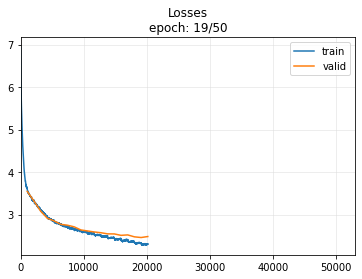

In [ ]:
# ReduceLROnPlateau(monitor='valid_loss', patience=1), CustomTransformerv4
try: del dls, learn, model, custom_head; gc.collect()
except: pass
# _splits = (splits[0][:100], splits[1][:100])
dls = get_ts_dls(X, y_cat, splits=splits, bs=[64, 512], path=PATH)
d_model = 512
custom_head = nn.Sequential(LinLnDrop(d_model, d_model, p=0., act=Mish()), LinLnDrop(d_model, len(i2p), p=0))
model = CustomTransformerv4(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=6, n_heads=16, kss=[1, 3, 5, 7, 9], maxpool=True,
                            n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)
cbs=[ShowGraph(), 
     ReduceLROnPlateau(monitor='valid_loss', patience=1),
     EarlyStoppingCallback(monitor="valid_cat_mae", comp=np.less, patience=5), # 10% of epochs
     SaveModelCallback(fname="281021_01C_C", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, loss_func=CrossEntropyLossFlat(), metrics=[cat_mae, accuracy], cbs=cbs)
print(f"#parameters:{count_parameters(learn.model)}")
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit_one_cycle(50, 3e-4, pct_start=3/50)
learn.export("models/281021_01C_C.pkl")

epoch,train_loss,train_cat_mae,train_accuracy,valid_loss,valid_cat_mae,valid_accuracy,time
0,3.582530,2.069726,0.056943,3.555022,0.814982,0.075401,02:40
1,3.284643,0.748252,0.083039,3.278911,0.562963,0.088477,02:41
2,3.109796,0.575214,0.097808,3.074190,0.486119,0.105714,02:41
3,2.945242,0.454916,0.112759,2.940683,0.426885,0.116970,02:41
4,2.841060,0.385933,0.124501,2.864072,0.388725,0.125532,02:41
5,2.767246,0.348446,0.133800,2.784736,0.342578,0.131539,02:41
6,2.696297,0.315688,0.141388,2.815719,0.384619,0.134281,02:41
7,2.661250,0.298100,0.147571,2.675906,0.291293,0.143696,02:41
8,2.604343,0.279405,0.153750,2.638948,0.284672,0.149009,02:41
9,2.570928,0.266155,0.159043,2.618920,0.267885,0.149760,02:41


Better model found at epoch 0 with valid_cat_mae value: 0.8149816976427112.


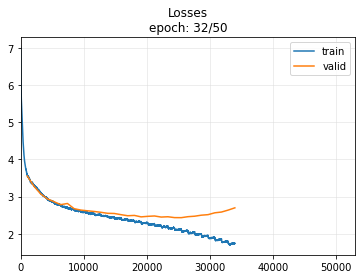

Better model found at epoch 1 with valid_cat_mae value: 0.5629634145410851.
Better model found at epoch 2 with valid_cat_mae value: 0.48611941918337714.
Better model found at epoch 3 with valid_cat_mae value: 0.4268853192555838.
Better model found at epoch 4 with valid_cat_mae value: 0.3887246251938935.
Better model found at epoch 5 with valid_cat_mae value: 0.34257830157857155.
Better model found at epoch 7 with valid_cat_mae value: 0.2912926768233641.
Better model found at epoch 8 with valid_cat_mae value: 0.2846716263553965.
Better model found at epoch 9 with valid_cat_mae value: 0.2678853002934166.
Better model found at epoch 11 with valid_cat_mae value: 0.26776230648030125.
Better model found at epoch 12 with valid_cat_mae value: 0.2593705411062785.
Better model found at epoch 13 with valid_cat_mae value: 0.24892771413285897.
Better model found at epoch 14 with valid_cat_mae value: 0.23761729159703687.
Better model found at epoch 15 with valid_cat_mae value: 0.22705123786767412.
B

KeyboardInterrupt: ignored

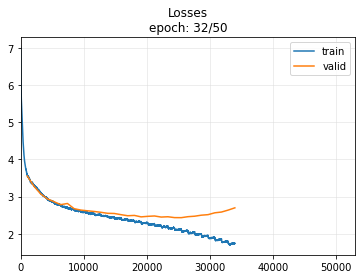

In [ ]:
try: del dls, learn, model, custom_head; gc.collect()
except: pass
# _splits = (splits[0][:100], splits[1][:100])
dls = get_ts_dls(X, y_cat, splits=splits, bs=[64, 512], path=PATH)
d_model = 512
custom_head = nn.Sequential(LinLnDrop(d_model, d_model, p=0., act=Mish()), LinLnDrop(d_model, len(i2p), p=0))
model = CustomTransformerv4(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=6, n_heads=16, kss=[1, 3, 5, 7, 9], maxpool=True,
                            n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)
cbs=[ShowGraph(), 
     ReduceLROnPlateau(monitor='valid_loss', patience=3),
     # EarlyStoppingCallback(monitor="valid_cat_mae", comp=np.less, patience=3),
     SaveModelCallback(fname="281021_01C_C", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, loss_func=CrossEntropyLossFlat(), metrics=[cat_mae, accuracy], cbs=cbs)
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit_one_cycle(50, 3e-4, pct_start=3/50)
learn.export("models/281021_01C_C.pkl")

epoch,train_loss,train_cat_mae,train_accuracy,valid_loss,valid_cat_mae,valid_accuracy,time
0,3.718317,1.860455,0.051348,3.711955,0.951996,0.065338,02:11
1,3.289646,0.758588,0.076910,3.297219,0.632108,0.090320,02:11
2,3.032842,0.523044,0.099652,2.979319,0.412680,0.112305,02:11
3,2.855416,0.404186,0.118869,2.832510,0.348884,0.126862,02:11
4,2.756670,0.340059,0.132617,2.750643,0.317229,0.134475,02:11
5,2.677155,0.302729,0.143099,2.667654,0.293635,0.144289,02:12
6,2.608031,0.278847,0.151504,2.635443,0.286647,0.148458,02:11
7,2.552527,0.259960,0.158982,2.575074,0.254628,0.153637,02:12
8,2.513700,0.245403,0.166358,2.542992,0.242703,0.158474,02:11
9,2.464686,0.231290,0.173709,2.520080,0.240925,0.162820,02:11


Better model found at epoch 0 with valid_cat_mae value: 0.9519961066248364.


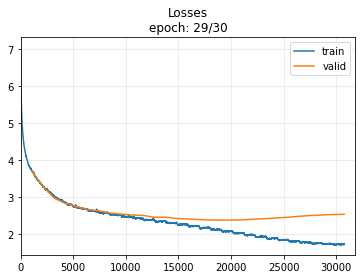

Better model found at epoch 1 with valid_cat_mae value: 0.632108416494856.
Better model found at epoch 2 with valid_cat_mae value: 0.41267953384074973.
Better model found at epoch 3 with valid_cat_mae value: 0.348883947457603.
Better model found at epoch 4 with valid_cat_mae value: 0.3172292301069122.
Better model found at epoch 5 with valid_cat_mae value: 0.29363514990042666.
Better model found at epoch 6 with valid_cat_mae value: 0.2866470980071495.
Better model found at epoch 7 with valid_cat_mae value: 0.2546282910164976.
Better model found at epoch 8 with valid_cat_mae value: 0.24270301588651233.
Better model found at epoch 9 with valid_cat_mae value: 0.24092519622420727.
Better model found at epoch 10 with valid_cat_mae value: 0.23456480878062633.
Better model found at epoch 11 with valid_cat_mae value: 0.22009614738454056.
Better model found at epoch 13 with valid_cat_mae value: 0.20986599721296648.
Better model found at epoch 14 with valid_cat_mae value: 0.20621124071509753.
Be

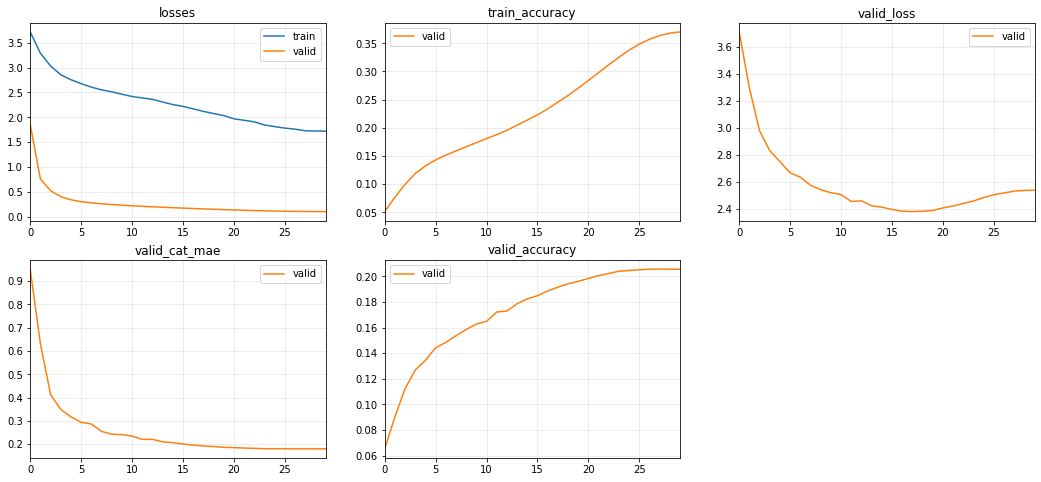

In [ ]:
try: del dls, learn, model, custom_head; gc.collect()
except: pass
# _splits = (splits[0][:100], splits[1][:100])
dls = get_ts_dls(X, y_cat, splits=splits, bs=[64, 512], path=PATH)
hidden_size = [512] * 3
custom_head = nn.Sequential(Transpose(1,2), LinLnDrop(hidden_size[0]*2, hidden_size[0], p=0., act=Mish()), LinLnDrop(hidden_size[0], len(i2p), p=0))
model = CustomLSTMv4(dls.vars, len(i2p), dls.len, hidden_size=hidden_size, kss=[1, 3, 5, 7, 9], maxpool=True,
                            n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)
cbs=[ShowGraph(), 
     ReduceLROnPlateau(monitor='valid_loss', patience=3),
     # EarlyStoppingCallback(monitor="valid_cat_mae", comp=np.less, patience=3),
     SaveModelCallback(fname="281021_01C_C", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, loss_func=CrossEntropyLossFlat(), metrics=[cat_mae, accuracy], cbs=cbs)
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit_one_cycle(30, 1e-3, pct_start=3/30)
learn.export("models/281021_01C_C.pkl")

In [ ]:
# epoch train_loss 	train_mae   train_ac 	valid_loss 	valid_mae 	valid_acc 	time
# 0 	3.605281 	2.078701 	0.055520 	3.580608 	0.813044 	0.073482 	02:35
# 1 	3.330121 	0.740648 	0.080761 	3.361331 	0.696812 	0.086365 	02:34
# 2 	3.133365 	0.583212 	0.094414 	3.144183 	0.531257 	0.101138 	02:35
# 3 	2.989068 	0.470308 	0.108640 	2.967997 	0.425761 	0.114468 	02:34
# 4 	2.867441 	0.398620 	0.120198 	2.846249 	0.356893 	0.122483 	02:34
# 5 	2.795697 	0.358241 	0.128952 	2.806258 	0.344918 	0.126511 	02:34
# 6 	2.732992 	0.327450 	0.137264 	2.724580 	0.318457 	0.137672 	02:35
# 7 	2.670089 	0.302478 	0.144027 	2.684890 	0.294199 	0.142714 	02:34
# 8 	2.623363 	0.282686 	0.150582 	2.635140 	0.274479 	0.147788 	02:35
# 9 	2.578494 	0.267340 	0.156815 	2.601961 	0.268750 	0.151040 	02:35
# 10 	2.534020 	0.253681 	0.162939 	2.551131 	0.246924 	0.157321 	02:35
# 11 	2.486732 	0.238910 	0.169931 	2.512794 	0.236965 	0.163219 	02:35
# 12 	2.462879 	0.228386 	0.176192 	2.494587 	0.234295 	0.164447 	02:35
# 13 	2.412362 	0.216666 	0.183329 	2.464361 	0.225436 	0.169814 	02:35
# 14 	2.363836 	0.206202 	0.190903 	2.458034 	0.223795 	0.173883 	02:35
# 15 	2.331583 	0.196972 	0.198937 	2.420549 	0.211752 	0.176990 	02:35
# 16 	2.286113 	0.187092 	0.208021 	2.399292 	0.206300 	0.182765 	02:35
# 17 	2.230726 	0.178017 	0.217900 	2.372163 	0.198946 	0.187739 	02:35
# 18 	2.197440 	0.169766 	0.228342 	2.353729 	0.193374 	0.190283 	02:35
# 19 	2.154339 	0.161508 	0.238782 	2.351317 	0.191780 	0.191980 	02:35
# 20 	2.089092 	0.154412 	0.251185 	2.333481 	0.186584 	0.198549 	02:35
# 21 	2.053262 	0.147080 	0.263647 	2.330546 	0.184747 	0.202195 	02:35
# 22 	1.997981 	0.140860 	0.276362 	2.325260 	0.180506 	0.205885 	02:35
# 23 	1.956878 	0.135006 	0.288861 	2.328790 	0.179228 	0.209299 	02:35
# 24 	1.930131 	0.129976 	0.300736 	2.332591 	0.177088 	0.211355 	02:36
# 25 	1.894287 	0.125836 	0.311378 	2.336740 	0.176192 	0.214082 	02:35
# 26 	1.884040 	0.122271 	0.320366 	2.344441 	0.175636 	0.215374 	02:36
# 27 	1.848135 	0.119767 	0.327345 	2.347848 	0.174952 	0.216219 	02:36
# 28 	1.829357 	0.118042 	0.332113 	2.350867 	0.174858 	0.216345 	02:36
# 29 	1.831932 	0.117143 	0.334570 	2.351584 	0.174828 	0.216383 	02:36

In [ ]:
try: del dls, learn, model, custom_head; gc.collect()
except: pass
# _splits = (splits[0][:100], splits[1][:100])
dls = get_ts_dls(X, y_cat, splits=splits, bs=[64, 512], path=PATH)
d_model = 512
custom_head = nn.Sequential(LinLnDrop(d_model, d_model, p=0., act=Mish()), LinLnDrop(d_model, len(i2p), p=0))
model = CustomTransformerv4(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=6, n_heads=16, kss=[1, 3, 5, 7, 9], maxpool=True,
                            n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)
cbs=[ShowGraph(), 
     EarlyStoppingCallback(monitor="valid_cat_mae", comp=np.less, patience=3),
     SaveModelCallback(fname="281021_01C_C", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, loss_func=CrossEntropyLossFlat(), metrics=[cat_mae, accuracy], cbs=cbs)
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit_one_cycle(50, 3e-4, pct_start=3/50)
learn.export("models/281021_01C_C.pkl")

epoch,train_loss,train_cat_mae,train_accuracy,valid_loss,valid_cat_mae,valid_accuracy,time
0,3.589414,2.100149,0.056641,3.550783,0.797787,0.073908,02:42
1,3.289288,0.752244,0.082001,3.280737,0.627339,0.090774,02:40
2,3.131311,0.579310,0.097558,3.106325,0.529151,0.103686,02:41
3,2.956654,0.455296,0.112777,2.950366,0.416203,0.117934,02:41
4,2.845257,0.388822,0.124507,2.860870,0.369044,0.124783,02:41
5,2.774796,0.345086,0.134068,2.779530,0.349536,0.134636,02:41
6,2.709396,0.315592,0.141462,2.703274,0.295407,0.139213,02:41
7,2.646297,0.292082,0.148595,2.672136,0.299325,0.146421,02:41
8,2.614696,0.274759,0.155439,2.635510,0.288323,0.149190,02:41
9,2.560950,0.259063,0.161655,2.595586,0.263607,0.154664,02:41


Better model found at epoch 0 with valid_cat_mae value: 0.797787139274889.


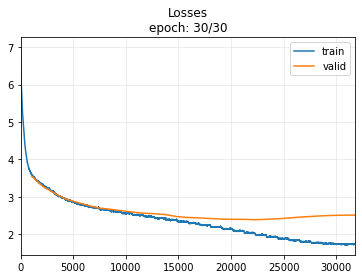

Better model found at epoch 1 with valid_cat_mae value: 0.6273394944512843.
Better model found at epoch 2 with valid_cat_mae value: 0.5291508313044186.
Better model found at epoch 3 with valid_cat_mae value: 0.4162029105836998.
Better model found at epoch 4 with valid_cat_mae value: 0.3690438680242124.
Better model found at epoch 5 with valid_cat_mae value: 0.34953572148998363.
Better model found at epoch 6 with valid_cat_mae value: 0.295407145992035.
Better model found at epoch 8 with valid_cat_mae value: 0.2883225392966056.
Better model found at epoch 9 with valid_cat_mae value: 0.2636071887881672.
Better model found at epoch 10 with valid_cat_mae value: 0.25941107315832784.
Better model found at epoch 11 with valid_cat_mae value: 0.2541025390539947.
Better model found at epoch 12 with valid_cat_mae value: 0.2431857898972732.
Better model found at epoch 13 with valid_cat_mae value: 0.2258372563202286.
Better model found at epoch 14 with valid_cat_mae value: 0.217727002353687.
Better 

RuntimeError: ignored

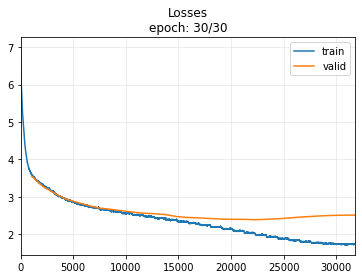

In [ ]:
try: del dls, learn, model, custom_head; gc.collect()
except: pass
# _splits = (splits[0][:100], splits[1][:100])
dls = get_ts_dls(X, y_cat, splits=splits, bs=[64, 512], path=PATH)
d_model = 512
custom_head = nn.Sequential(LinLnDrop(d_model, d_model, p=0., act=Mish()), LinLnDrop(d_model, len(i2p), p=0))
model = CustomTransformerv4(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=6, n_heads=16, kss=[1, 3, 5, 7, 9], maxpool=True,
                            n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)
cbs=[ShowGraph(), 
     EarlyStoppingCallback(monitor="valid_cat_mae", comp=np.less, patience=3),
     SaveModelCallback(fname="281021_01C_C", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, loss_func=CrossEntropyLossFlat(), metrics=[cat_mae, accuracy], cbs=cbs)
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit_one_cycle(30, 3e-4, pct_start=3/30)
learn.export("models/281021_01C_C.pkl")

epoch,train_loss,train_cat_mae,train_accuracy,valid_loss,valid_cat_mae,valid_accuracy,time
0,3.923279,2.566371,0.050303,3.832779,1.255329,0.061849,02:44
1,3.629276,1.172006,0.068042,3.548812,0.882713,0.075017,02:44
2,3.420147,0.956692,0.078924,3.400121,0.814186,0.085595,02:44
3,3.336920,0.820134,0.088710,3.316406,0.760504,0.091746,02:44
4,3.223003,0.728717,0.095253,3.147613,0.565840,0.102374,02:44
5,3.176935,0.665802,0.100694,3.122319,0.580603,0.105439,02:44
6,3.117305,0.620925,0.105149,3.061390,0.526358,0.111059,02:44
7,3.080181,0.578782,0.110131,3.078489,0.519316,0.109776,02:44
8,3.033359,0.545877,0.113542,2.945487,0.448008,0.117843,02:44
9,2.985863,0.515997,0.117303,2.984679,0.468133,0.117074,02:45


Better model found at epoch 0 with valid_cat_mae value: 1.2553291323351539.


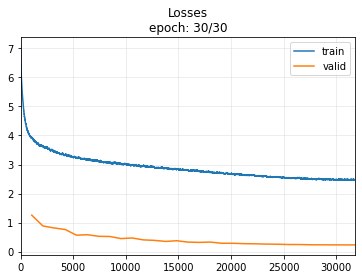

Better model found at epoch 1 with valid_cat_mae value: 0.8827127366313106.
Better model found at epoch 2 with valid_cat_mae value: 0.814185731999879.
Better model found at epoch 3 with valid_cat_mae value: 0.7605040573171991.
Better model found at epoch 4 with valid_cat_mae value: 0.565839676108212.
Better model found at epoch 6 with valid_cat_mae value: 0.5263584291553254.
Better model found at epoch 7 with valid_cat_mae value: 0.5193164509973962.
Better model found at epoch 8 with valid_cat_mae value: 0.4480083419440226.
Better model found at epoch 10 with valid_cat_mae value: 0.40320225488885203.
Better model found at epoch 11 with valid_cat_mae value: 0.38640602875668756.
Better model found at epoch 12 with valid_cat_mae value: 0.350062987580868.
Better model found at epoch 14 with valid_cat_mae value: 0.32635103830348.
Better model found at epoch 15 with valid_cat_mae value: 0.3172103617378547.
Better model found at epoch 17 with valid_cat_mae value: 0.28663358732313304.
Better m

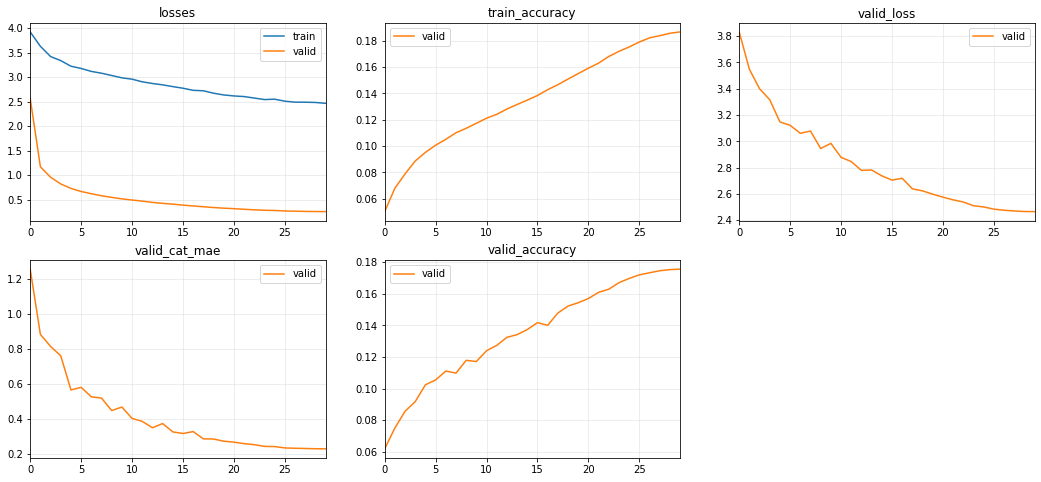

In [ ]:
# BatchSubsampler(step_pct=1., update_y=True)
try: del dls, learn, model, custom_head; gc.collect()
except: pass
dls = get_ts_dls(X, y_cat, splits=splits, bs=[64, 512], path=PATH)
model = CustomTransformer(dls.vars, len(i2p), dls.len, d_model=512, n_layers=6, n_heads=16, kss=[1, 3, 5, 7, 9], maxpool=True,
                          n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos)
cbs=[ShowGraph(), 
     BatchSubsampler(step_pct=1., update_y=True), 
     SaveModelCallback(fname="281021_01B_C", monitor="valid_cat_mae", comp=np.less),
     EarlyStoppingCallback(monitor="valid_cat_mae", comp=np.less, patience=5)
     ]
learn = Learner(dls, model=model, loss_func=CrossEntropyLossFlat(), metrics=[cat_mae, accuracy], cbs=cbs, wd=.1).to_fp16()
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit_one_cycle(30, 3e-4, pct_start=3/30)
learn.export("models/281021_01B_C.pkl")

In [ ]:
# epoch train_loss 	train_mae   train_ac 	valid_loss 	valid_mae 	valid_acc 	time
# 0 	3.613202 	2.227413 	0.055599 	3.584188 	0.816879 	0.072061 	02:34
# 1 	3.337174 	0.735863 	0.080441 	3.292030 	0.604191 	0.088873 	02:34
# 2 	3.149378 	0.586387 	0.094391 	3.139317 	0.526506 	0.101120 	02:35
# 3 	2.983518 	0.473637 	0.108500 	2.965898 	0.428184 	0.114192 	02:34
# 4 	2.872653 	0.403585 	0.119592 	2.882422 	0.385604 	0.124041 	02:35
# 5 	2.802179 	0.359206 	0.128620 	2.783278 	0.340792 	0.130389 	02:34
# 6 	2.749158 	0.331256 	0.135945 	2.735731 	0.320063 	0.136955 	02:35
# 7 	2.692303 	0.306847 	0.142842 	2.725849 	0.319967 	0.139004 	02:35
# 8 	2.631779 	0.290404 	0.148996 	2.646270 	0.280016 	0.144826 	02:35
# 9 	2.593568 	0.275438 	0.154025 	2.661217 	0.293119 	0.146335 	02:35
# 10 	2.569534 	0.262160 	0.159547 	2.590111 	0.263507 	0.153497 	02:35
# 11 	2.534283 	0.252773 	0.164577 	2.607458 	0.289017 	0.153037 	02:35
# 12 	2.510451 	0.241605 	0.169556 	2.557240 	0.256960 	0.159361 	02:35
# 13 	2.476007 	0.232124 	0.174581 	2.517863 	0.236399 	0.161216 	02:35
# 14 	2.451564 	0.224460 	0.180179 	2.538573 	0.251067 	0.162437 	02:35
# 15 	2.425758 	0.216799 	0.185372 	2.504552 	0.235574 	0.165063 	02:35
# 16 	2.397434 	0.209803 	0.190387 	2.488221 	0.230391 	0.167371 	02:35
# 17 	2.359140 	0.202923 	0.195996 	2.454788 	0.220856 	0.172815 	02:35
# 18 	2.313251 	0.196330 	0.202079 	2.444500 	0.216903 	0.174848 	02:35
# 19 	2.303319 	0.190182 	0.208475 	2.427008 	0.214240 	0.176594 	02:35
# 20 	2.271317 	0.183914 	0.214795 	2.432944 	0.210605 	0.177782 	02:35
# 21 	2.243704 	0.177452 	0.222230 	2.428734 	0.209757 	0.180292 	02:35
# 22 	2.197532 	0.172691 	0.229517 	2.406757 	0.203706 	0.184785 	02:35
# 23 	2.166363 	0.167087 	0.237514 	2.404079 	0.201428 	0.185557 	02:35
# 24 	2.140646 	0.161077 	0.246370 	2.397640 	0.198133 	0.186950 	02:36
# 25 	2.114762 	0.155727 	0.256045 	2.441636 	0.203228 	0.184347 	02:36
# 26 	2.079962 	0.150433 	0.265628 	2.415986 	0.197258 	0.190880 	02:36
# 27 	2.024981 	0.145222 	0.276558 	2.410757 	0.192292 	0.194453 	02:36
# 28 	1.989311 	0.139783 	0.288046 	2.434793 	0.193928 	0.194561 	02:36
# 29 	1.943724 	0.134740 	0.299994 	2.438683 	0.190967 	0.196721 	02:35
# 30 	1.892670 	0.129465 	0.313125 	2.486618 	0.192230 	0.194092 	02:36
# 31 	1.860396 	0.124341 	0.327526 	2.497403 	0.190643 	0.197947 	02:36
# 32 	1.813914 	0.119478 	0.341562 	2.522474 	0.187208 	0.201463 	02:36
# 33 	1.770207 	0.114588 	0.356620 	2.560183 	0.186826 	0.202457 	02:36
# 34 	1.720621 	0.109658 	0.371808 	2.601006 	0.186938 	0.203486 	02:36
# 35 	1.682816 	0.105195 	0.387512 	2.644681 	0.186954 	0.202684 	02:36
# 36 	1.635709 	0.100814 	0.403752 	2.693488 	0.187281 	0.203217 	02:36
# 37 	1.576837 	0.096623 	0.418670 	2.753549 	0.187558 	0.204972 	02:36
# 38 	1.539159 	0.092678 	0.434595 	2.804734 	0.188094 	0.205611 	02:36
# 39 	1.513704 	0.089209 	0.448793 	2.858224 	0.188540 	0.206070 	02:36
# 40 	1.475187 	0.085880 	0.462880 	2.903427 	0.189383 	0.206526 	02:36
# 41 	1.433241 	0.082767 	0.476002 	2.953525 	0.190235 	0.206740 	02:36
# 42 	1.420470 	0.080141 	0.487571 	2.990540 	0.191078 	0.207097 	02:36
# 43 	1.383447 	0.077939 	0.497716 	3.029717 	0.192323 	0.207210 	02:36
# 44 	1.368839 	0.076032 	0.506005 	3.058709 	0.192874 	0.207270 	02:36
# 45 	1.356365 	0.074476 	0.513051 	3.079198 	0.193678 	0.207603 	02:36
# 46 	1.329926 	0.073296 	0.518261 	3.094316 	0.194323 	0.207248 	02:36
# 47 	1.334096 	0.072380 	0.522280 	3.102815 	0.194579 	0.207684 	02:36
# 48 	1.325449 	0.071779 	0.524798 	3.107084 	0.194799 	0.207629 	02:36
# 49 	1.316881 	0.071491 	0.526183 	3.107843 	0.194834 	0.207613 	02:36

epoch,train_loss,train_cat_mae,train_accuracy,valid_loss,valid_cat_mae,valid_accuracy,time
0,3.536066,2.045602,0.060930,3.512931,0.778750,0.079912,02:32
1,3.295511,0.703801,0.084877,3.328008,0.661453,0.088274,02:31
2,3.125248,0.567936,0.096674,3.102692,0.495934,0.103921,02:31
3,2.960836,0.461544,0.109875,2.965190,0.415736,0.114846,02:32
4,2.882545,0.397433,0.120724,2.877080,0.372152,0.121870,02:31
5,2.795837,0.357465,0.129840,2.813622,0.346597,0.129922,02:31
6,2.742331,0.329097,0.137419,2.730167,0.308076,0.136624,02:31
7,2.669639,0.305290,0.144837,2.693885,0.304483,0.141503,02:32
8,2.643974,0.289904,0.150613,2.637818,0.274951,0.145853,02:31
9,2.612307,0.273395,0.156500,2.631913,0.280926,0.146509,02:31


Better model found at epoch 0 with valid_cat_mae value: 0.7787501196100273.


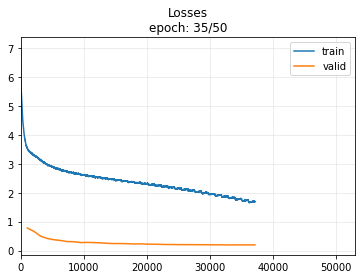

Better model found at epoch 1 with valid_cat_mae value: 0.6614526904073166.
Better model found at epoch 2 with valid_cat_mae value: 0.4959342322928586.
Better model found at epoch 3 with valid_cat_mae value: 0.41573586021382036.
Better model found at epoch 4 with valid_cat_mae value: 0.3721521406478981.
Better model found at epoch 5 with valid_cat_mae value: 0.3465967983021597.
Better model found at epoch 6 with valid_cat_mae value: 0.3080757416857539.
Better model found at epoch 7 with valid_cat_mae value: 0.3044831809229265.
Better model found at epoch 8 with valid_cat_mae value: 0.2749505727341327.
Better model found at epoch 10 with valid_cat_mae value: 0.2731707730577908.
Better model found at epoch 11 with valid_cat_mae value: 0.2634967738877566.
Better model found at epoch 12 with valid_cat_mae value: 0.24931393334146756.
Better model found at epoch 13 with valid_cat_mae value: 0.24056623132645935.
Better model found at epoch 15 with valid_cat_mae value: 0.2347388170730453.
Bett

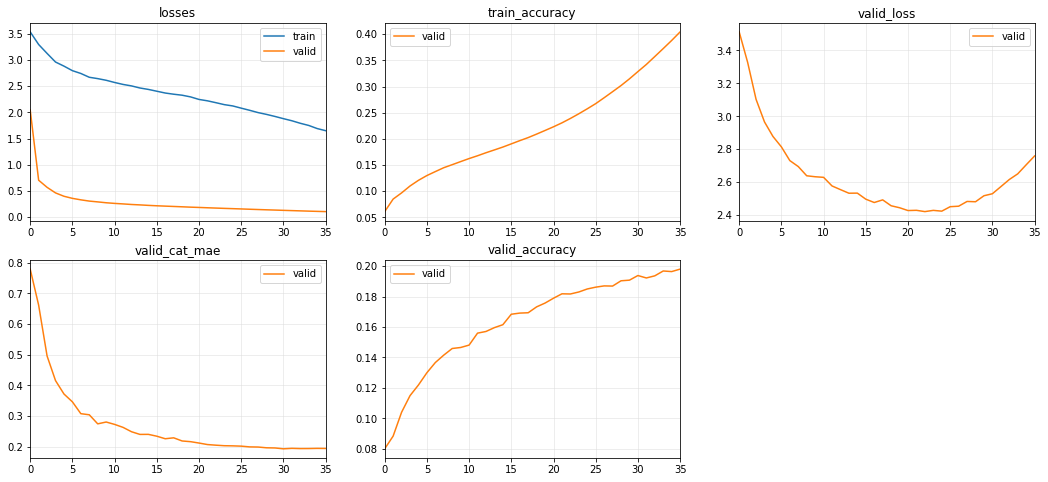

In [ ]:
# BASELINE
try: del dls, learn, model, custom_head; gc.collect()
except: pass
dls = get_ts_dls(X, y_cat, splits=splits, bs=[64, 512], path=PATH)
model = CustomTransformerv3(dls.vars, len(i2p), dls.len, d_model=512, n_layers=6, n_heads=16, kss=[1, 3, 5, 7, 9], maxpool=True,
                            n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos)
cbs=[ShowGraph(), 
     SaveModelCallback(fname="281021_01_C", monitor="valid_cat_mae", comp=np.less),
     EarlyStoppingCallback(monitor="valid_cat_mae", comp=np.less, patience=5)
     ]
learn = Learner(dls, model=model, loss_func=CrossEntropyLossFlat(), metrics=[cat_mae, accuracy], cbs=cbs)
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit_one_cycle(50, 3e-4, pct_start=3/50)
learn.export("models/281021_01_C.pkl")

In [ ]:
## y_masked
# epoch train_loss 	train_mae   train_ac 	valid_loss 	valid_mae 	valid_acc 	time
# 0 	4.465810 	1.770585 	0.039577 	4.585845 	1.198409 	0.052654 	02:08
# 1 	4.077074 	0.773690 	0.074876 	4.103554 	0.658560 	0.080432 	02:08
# 2 	3.871813 	0.553536 	0.094644 	3.959975 	0.555382 	0.093361 	02:08
# 3 	3.753756 	0.463168 	0.108265 	3.742971 	0.430664 	0.110672 	02:09
# 4 	3.643836 	0.407427 	0.120815 	3.640407 	0.383029 	0.124772 	02:09
# 5 	3.594482 	0.374454 	0.130366 	3.573602 	0.348834 	0.130474 	02:08
# 6 	3.522664 	0.343335 	0.139083 	3.605955 	0.360546 	0.126559 	02:08
# 7 	3.443985 	0.321163 	0.148156 	3.534229 	0.328371 	0.134944 	02:09
# 8 	3.223178 	0.264622 	0.175329 	3.305430 	0.253135 	0.172501 	02:09
# 9 	3.019685 	0.186163 	0.236210 	3.211066 	0.221702 	0.197149 	02:09

## y_unmasked
# epoch train_loss 	train_mae   train_ac 	valid_loss 	valid_mae 	valid_acc 	time
# 0 	4.089239 	1.157883 	0.062770 	4.082695 	0.745791 	0.077396 	02:15
# 1 	3.769519 	0.596982 	0.091249 	3.735700 	0.467884 	0.104919 	02:15
# 2 	3.580869 	0.439510 	0.114907 	3.557358 	0.365896 	0.124559 	02:15
# 3 	3.481462 	0.350121 	0.131739 	3.468236 	0.341239 	0.137189 	02:15
# 4 	3.372451 	0.299051 	0.145481 	3.361495 	0.274484 	0.149664 	02:14
# 5 	3.274799 	0.259842 	0.159277 	3.297483 	0.251127 	0.160018 	02:14
# 6 	3.183931 	0.225977 	0.175730 	3.216835 	0.225485 	0.172218 	02:14
# 7 	3.077138 	0.195353 	0.197552 	3.146343 	0.201761 	0.186812 	02:14
# 8 	2.999481 	0.171267 	0.222162 	3.106351 	0.189698 	0.198010 	02:15
# 9 	2.952842 	0.157403 	0.241333 	3.103508 	0.187715 	0.200364 	02:14

# Run 27/10/21

epoch,train_loss,train_cat_mae,train_accuracy,valid_loss,valid_cat_mae,valid_accuracy,time
0,3.613202,2.227413,0.055599,3.584188,0.816879,0.072061,02:34
1,3.337174,0.735863,0.080441,3.292030,0.604191,0.088873,02:34
2,3.149378,0.586387,0.094391,3.139317,0.526506,0.101120,02:35
3,2.983518,0.473637,0.108500,2.965898,0.428184,0.114192,02:34
4,2.872653,0.403585,0.119592,2.882422,0.385604,0.124041,02:35
5,2.802179,0.359206,0.128620,2.783278,0.340792,0.130389,02:34
6,2.749158,0.331256,0.135945,2.735731,0.320063,0.136955,02:35
7,2.692303,0.306847,0.142842,2.725849,0.319967,0.139004,02:35
8,2.631779,0.290404,0.148996,2.646270,0.280016,0.144826,02:35
9,2.593568,0.275438,0.154025,2.661217,0.293119,0.146335,02:35


Better model found at epoch 0 with valid_cat_mae value: 0.8168794828613695.


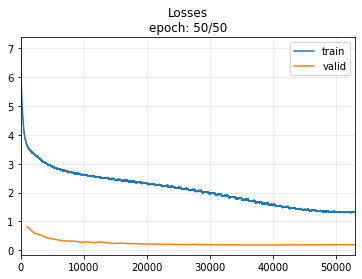

Better model found at epoch 1 with valid_cat_mae value: 0.6041912668173424.
Better model found at epoch 2 with valid_cat_mae value: 0.5265058819653669.
Better model found at epoch 3 with valid_cat_mae value: 0.42818374257813224.
Better model found at epoch 4 with valid_cat_mae value: 0.3856042395431583.
Better model found at epoch 5 with valid_cat_mae value: 0.3407920959744632.
Better model found at epoch 6 with valid_cat_mae value: 0.32006251372229705.
Better model found at epoch 7 with valid_cat_mae value: 0.3199670071628703.
Better model found at epoch 8 with valid_cat_mae value: 0.2800164968832391.
Better model found at epoch 10 with valid_cat_mae value: 0.2635069069007691.
Better model found at epoch 12 with valid_cat_mae value: 0.25695993225206404.
Better model found at epoch 13 with valid_cat_mae value: 0.23639911707868988.
Better model found at epoch 15 with valid_cat_mae value: 0.23557426652520158.
Better model found at epoch 16 with valid_cat_mae value: 0.23039093919084871.
B

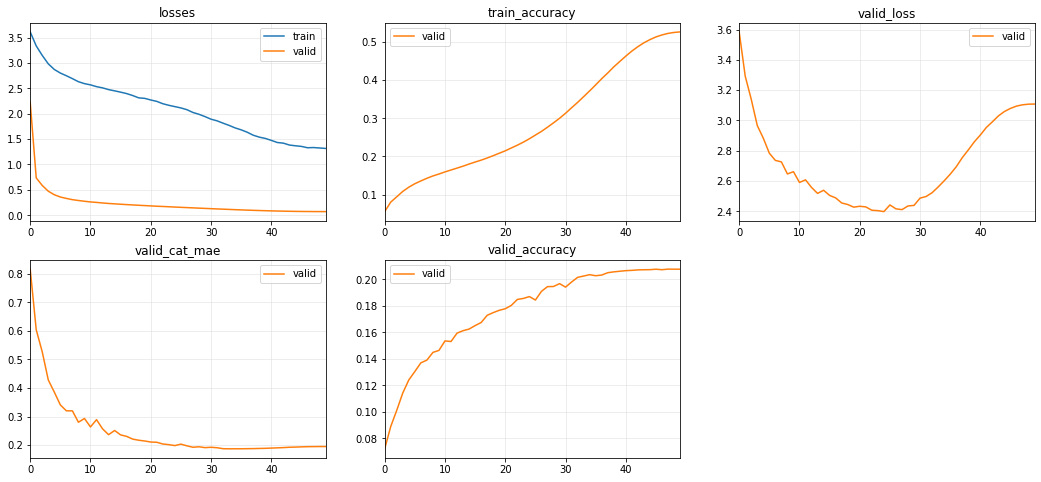

In [ ]:
try: del dls, learn, model, custom_head; gc.collect()
except: pass
dls = get_ts_dls(X, y_cat, splits=splits, bs=[64, 512], path=PATH)
d_model = 512
custom_head = nn.Sequential(LinLnDrop(d_model, d_model, p=0., act=Mish()), LinLnDrop(d_model, len(i2p), p=0))
model = CustomTransformer(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=6, n_heads=16, kss=[1, 3, 5, 7, 9], maxpool=True,
                          n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)
cbs=[ShowGraph(), 
     SaveModelCallback(fname="CustomTFM_50_epochs_271021_01_C", monitor="valid_cat_mae", comp=np.less),
     EarlyStoppingCallback()
     ]
learn = Learner(dls, model=model, loss_func=CrossEntropyLossFlat(), metrics=[cat_mae, accuracy], cbs=cbs)
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit_one_cycle(50, 3e-4, pct_start=3/50)
learn.export("models/CustomTFM_50_epochs_271021_01_C.pkl")

epoch,train_loss,train_cat_mae,train_accuracy,valid_loss,valid_cat_mae,valid_accuracy,time
0,3.605281,2.078701,0.055520,3.580608,0.813044,0.073482,02:35
1,3.330121,0.740648,0.080761,3.361331,0.696812,0.086365,02:34
2,3.133365,0.583212,0.094414,3.144183,0.531257,0.101138,02:35
3,2.989068,0.470308,0.108640,2.967997,0.425761,0.114468,02:34
4,2.867441,0.398620,0.120198,2.846249,0.356893,0.122483,02:34
5,2.795697,0.358241,0.128952,2.806258,0.344918,0.126511,02:34
6,2.732992,0.327450,0.137264,2.724580,0.318457,0.137672,02:35
7,2.670089,0.302478,0.144027,2.684890,0.294199,0.142714,02:34
8,2.623363,0.282686,0.150582,2.635140,0.274479,0.147788,02:35
9,2.578494,0.267340,0.156815,2.601961,0.268750,0.151040,02:35


Better model found at epoch 0 with valid_cat_mae value: 0.8130439627290732.


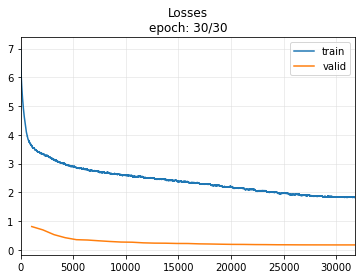

Better model found at epoch 1 with valid_cat_mae value: 0.696811664606799.
Better model found at epoch 2 with valid_cat_mae value: 0.5312566344683652.
Better model found at epoch 3 with valid_cat_mae value: 0.4257611371682825.
Better model found at epoch 4 with valid_cat_mae value: 0.35689263835119317.
Better model found at epoch 5 with valid_cat_mae value: 0.34491844522735515.
Better model found at epoch 6 with valid_cat_mae value: 0.31845683880978776.
Better model found at epoch 7 with valid_cat_mae value: 0.2941994539009421.
Better model found at epoch 8 with valid_cat_mae value: 0.2744790964505235.
Better model found at epoch 9 with valid_cat_mae value: 0.2687499840704707.
Better model found at epoch 10 with valid_cat_mae value: 0.24692440581317554.
Better model found at epoch 11 with valid_cat_mae value: 0.23696493520758666.
Better model found at epoch 12 with valid_cat_mae value: 0.2342945951002969.
Better model found at epoch 13 with valid_cat_mae value: 0.22543554641356656.
Bet

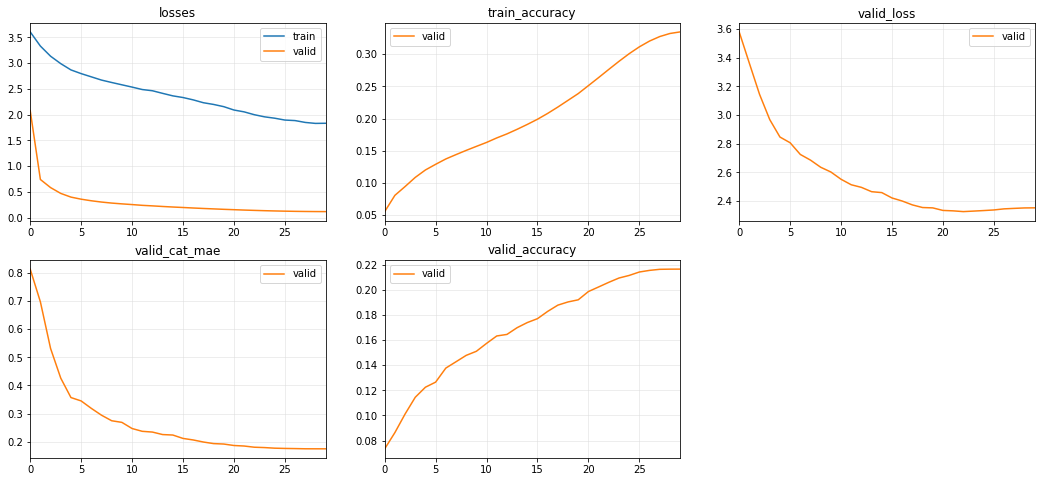

In [ ]:
try: del dls, learn, model, custom_head; gc.collect()
except: pass
dls = get_ts_dls(X, y_cat, splits=splits, bs=[64, 512], path=PATH)
d_model = 512
custom_head = nn.Sequential(LinLnDrop(d_model, d_model, p=0., act=Mish()), LinLnDrop(d_model, len(i2p), p=0))
model = CustomTransformer(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=6, n_heads=16, kss=[1, 3, 5, 7, 9], maxpool=True,
                          n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)
cbs=[ShowGraph(), 
     SaveModelCallback(fname="CustomLSTM_30_epochs_271021_01_C", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, loss_func=CrossEntropyLossFlat(), metrics=[cat_mae, accuracy], cbs=cbs)
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit_one_cycle(30, 3e-4, pct_start=3/30)
learn.export("models/CustomLSTM_30_epochs_271021_01_C.pkl")

epoch,train_loss,train_cat_mae,train_accuracy,valid_loss,valid_cat_mae,valid_accuracy,time
0,3.996772,1.734040,0.066586,3.928278,0.588524,0.091024,02:34
1,3.758474,0.552174,0.097880,3.788000,0.509679,0.102243,02:34
2,3.643479,0.443769,0.112716,3.649899,0.427255,0.115408,02:34
3,3.563797,0.384573,0.123709,3.585043,0.387978,0.123419,02:34
4,3.473248,0.343123,0.132606,3.500064,0.340304,0.132584,02:34
5,3.418456,0.310985,0.141356,3.427355,0.300433,0.140144,02:35
6,3.358616,0.286853,0.148666,3.355519,0.269954,0.150084,02:35
7,3.314297,0.266271,0.156859,3.344115,0.266896,0.151504,02:35
8,3.269381,0.248559,0.164876,3.300084,0.249851,0.158373,02:35
9,3.216276,0.231469,0.172930,3.265396,0.243504,0.164609,02:35


Better model found at epoch 0 with valid_cat_mae value: 0.5885235322147948.


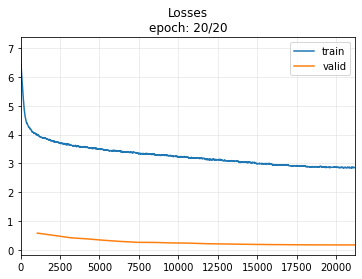

Better model found at epoch 1 with valid_cat_mae value: 0.5096786744370958.
Better model found at epoch 2 with valid_cat_mae value: 0.4272546501091721.
Better model found at epoch 3 with valid_cat_mae value: 0.38797792695915556.
Better model found at epoch 4 with valid_cat_mae value: 0.34030443016431694.
Better model found at epoch 5 with valid_cat_mae value: 0.30043312044616177.
Better model found at epoch 6 with valid_cat_mae value: 0.26995383260490374.
Better model found at epoch 7 with valid_cat_mae value: 0.26689587563203815.
Better model found at epoch 8 with valid_cat_mae value: 0.2498512159739502.
Better model found at epoch 9 with valid_cat_mae value: 0.24350410627155783.
Better model found at epoch 10 with valid_cat_mae value: 0.2247492968426611.
Better model found at epoch 11 with valid_cat_mae value: 0.21413910044741682.
Better model found at epoch 12 with valid_cat_mae value: 0.2061075811566953.
Better model found at epoch 13 with valid_cat_mae value: 0.19830679173697913.


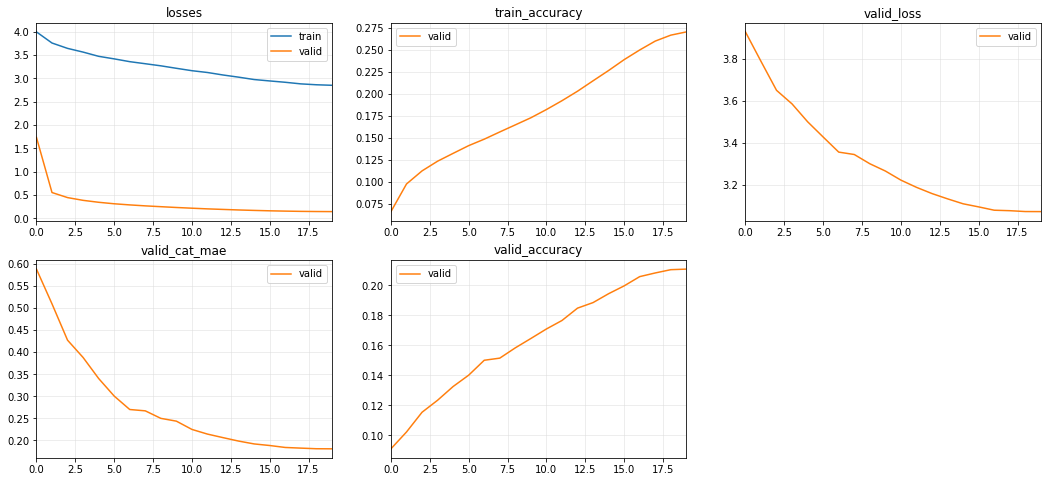

In [ ]:
try: del dls, learn, model, custom_head; gc.collect()
except: pass
dls = get_ts_dls(X, y_cat, splits=splits, bs=[64, 512], path=PATH)
d_model = 512
custom_head = nn.Sequential(LinLnDrop(d_model, d_model, p=0., act=Mish()), LinLnDrop(d_model, len(i2p), p=0))
model = CustomTransformer(dls.vars, len(i2p), dls.len, d_model=d_model, n_layers=6, n_heads=16, kss=[1, 3, 5, 7, 9], maxpool=True,
                          n_embeds=n_embeds, embed_dims=None, cat_pos=cat_pos, cont_pos=cont_pos, custom_head=custom_head)
cbs=[ShowGraph(), 
     SaveModelCallback(fname="CustomLSTM_200_epochs_271021_01_C", monitor="valid_cat_mae", comp=np.less)
     ]
learn = Learner(dls, model=model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[cat_mae, accuracy], cbs=cbs)
learn.recorder.train_metrics=True
# learn.lr_find()
learn.fit_one_cycle(20, 3e-4, pct_start=3/100)
learn.export("models/CustomLSTM_200_epochs_271021_01_C.pkl")

# Feature importance

In [39]:
learn = load_learner(PATH/f"models/301021_02C.pth", cpu=False)

In [44]:
X_valid = X[valid_split]
y_valid = y_cat_masked[valid_split]
X_valid

array([[[ 1.60000000e+01,  2.98000000e+02,  2.60000000e+02, ...,
          4.57000000e+02,  4.68000000e+02,  4.79000000e+02],
        [ 2.00000000e+00,  2.00000000e+00,  2.00000000e+00, ...,
          2.00000000e+00,  2.00000000e+00,  2.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 8.64151403e+00,  7.31606463e+01, -4.37918534e+00, ...,
          1.03721365e-01,  8.29112095e-02,  6.57326787e-02],
        [-1.90234406e-01,  7.88117821e-01,  7.30060586e-01, ...,
          8.71643630e-01,  8.73227472e-01,  8.74581703e-01],
        [-2.89715537e-01, -2.43613634e-01, -2.08426662e-01, ...,
          1.75328935e+00,  1.80481067e+00,  1.85618277e+00]],

       [[ 5.00000000e+00,  2.00000000e+02,  5.60000000e+02, ...,
          5.18000000e+02,  5.23000000e+02,  5.27000000e+02],
        [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
          1.00000000e+00,  1.00000000e

In [41]:
# Adapted from https://www.kaggle.com/cdeotte/lstm-feature-importance by Chris Deotte

X_valid = X[valid_split]
y_valid = y_cat_masked[valid_split]


results = []
print(' Computing feature importance...')
# mask = np.isnan(y_valid)
mask = y_valid == -1
y_valid = i2p[y_valid]

COLS = ['BASELINE'] + list(features)
for k in progress_bar(range(len(COLS))):
    if k>0: 
        save_feat = X_valid[:, k-1].copy()
        # np.random.shuffle(X_valid[:, k-1])
        X_valid[:, k-1] = np.random.permutation(X_valid[:, k-1].flatten()).reshape(X_valid[:, k-1].shape)
    oof_preds = learn.get_X_preds(X_valid)#[0].numpy()
    break

 Computing feature importance...


AttributeError: ignored

In [ ]:
# Adapted from https://www.kaggle.com/cdeotte/lstm-feature-importance by Chris Deotte

X_valid = X[valid_split]
y_valid = y_cat_masked[valid_split]


results = []
print(' Computing feature importance...')
# mask = np.isnan(y_valid)
mask = y_valid == -1
y_valid = i2p[y_valid]

COLS = ['BASELINE'] + list(features)
for k in progress_bar(range(len(COLS))):
    if k>0: 
        save_feat = X_valid[:, k-1].copy()
        # np.random.shuffle(X_valid[:, k-1])
        X_valid[:, k-1] = np.random.permutation(X_valid[:, k-1].flatten()).reshape(X_valid[:, k-1].shape)
    oof_preds = learn.get_X_preds(X_valid)[0].numpy()
    if oof_preds.ndim == 3: 
        oof_preds = i2p[np.argmax(oof_preds, -1)]
    mae_value = np.mean(np.abs(oof_preds[~mask]-y_valid[~mask]))
    results.append({'feature':COLS[k],'mae':mae_value})
    print(f"{k:2} feature: {COLS[k]:20} mae:{mae_value:5.3f}")
    if k>0: 
        X_valid[:, k-1] = save_feat

# DISPLAY LSTM FEATURE IMPORTANCE
print()
df = pd.DataFrame(results)
df = df.sort_values('mae')
plt.figure(figsize=(10,.5*len(results)))
plt.barh(np.arange(len(results)),df.mae,color="darkblue")
plt.yticks(np.arange(len(results)),df.feature.values)
plt.title('Feature Importance',size=16)
plt.ylim((-1,len(results)))
plt.show()
                    
# SAVE LSTM FEATURE IMPORTANCE
# df = df.sort_values('mae',ascending=False)
# df.to_csv('feature_importance.csv',index=False)

 Computing feature importance...
